<a href="https://www.kaggle.com/code/wattuginu/ica-individual-elements?scriptVersionId=198251839" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# ICA Exploration for Individual Elements

## Import Modul

In [1]:
!pip install scikit-bio

import branca.colormap as cm
import geopandas as gpd
import folium
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import seaborn as sns
import scipy.stats as st
from IPython.display import display
from shapely.geometry import Point
from skbio.stats.composition import clr
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, FastICA
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 27.7 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / - \ | / - done
  Getting requirements to build wheel ... - \ | / - \ | / done
  Preparing metadata (pyproject.toml) ... - \ | / - \ | / - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 66.1 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / - \ done
  Getting requirements to build wheel ... - \ | / - done
  Preparing metadata (pyproject.toml) ... - \ done
  Created wheel for scikit-bio: filename=scikit_bio-0.6.2-cp310-cp310-linux_x86_64.whl size=2504426 sha256=9dcec00beb54a13eee80861bb69e9526f42b8ac1b1a7a0b928d05f9a1c4157de
  Stored in directory: /root/.cache/pip/wheels/f3/9c/ed/c2b94011fd3765a19330df93f81265e178098dd86c047c1566
  Created wheel for biom-format: filename=biom_format-2.1.16-cp310-cp310-linux_x86_64.whl size=11812704 sha256=e6ab3db0bb93accdf28e2551

## Preprocessing

In [2]:
def ratio(df):
    
    # Create new ratio
    # Log LILE/LILE
    df["Rb/Sr"] = df["Rb"]/df["Sr"]
    # Log LILE/HFSE
    df["Ba/Nb"] =  df["Ba"]/df["Nb"]
    df["Sr/Y"]  =  df["Sr"]/df["Y"]
    df["Rb/Yb"] =  df["Rb"]/df["Yb"]
    # Log HFSE/HFSE
    df["Nb/Er"] =  df["Nb"]/df["Er"]
    df["Nb/Zr"] =  df["Nb"]/df["Zr"]
    df["La/Yb"] =  df["La"]/df["Yb"]
    df["Nb/Y"]  =  df["Nb"]/df["Y"]
    df["Th/Ce"] =  df["Th"]/df["Ce"]
    df["Eu/La"] =  df["Eu"]/df["La"]
    # Custom
    df["Th/Nb"] =  df["Th"]/df["Nb"]
    df["Er/Ba"] =  df["Er"]/df["Ba"]
    df["Th/Y"] =  df["Th"]/df["Y"]
    df["Sr/Rb"] = df["Sr"]/df["Rb"]
    df["Er/Th"] = df["Er"]/df["Th"]
    df["Nb/Th"] =  df["Nb"]/df["Th"]
    
    ratio = [
        "Ba/Nb", "Nb/Zr", "La/Yb", "Sr/Y", "Rb/Sr", "Er/Ba", "Th/Y", "Nb/Th",
        "Th/Ce", "Eu/La", "Rb/Yb", "Nb/Y", "Nb/Er", "Th/Nb", "Sr/Rb", "Er/Th"
    ]
    
    frame = [
        "Location", "Longitude", "Latitude", "AGE", "Sample Name", "Island Arc", "SiO2"
    ]
    
    # Separate the data based on the variable
    ratioData = df[ratio]
    frameData = df[frame]
    
    # change inf value to nan 
    ratioData = ratioData.copy()
    ratioData.loc[:, :] = ratioData.loc[:, :].replace([np.inf, -np.inf], np.nan).replace([0], np.nan)
    
    # Drop Na value
    cleanData = ratioData.dropna(axis=0)
    
    # elimination with z-score
    data = cleanData
    zScore = np.abs(st.zscore(data))
    cleanDataZScore1 = data[(zScore < 3).all(axis=1)]
    cleanDataZScore = cleanDataZScore1
    
    # concat Z-score and frame dataframe
    concatData = pd.concat([cleanDataZScore, frameData], axis=1, join='inner')
    concatData.reset_index(drop=True, inplace=True)
    preprocessingRatioData = concatData[ratio]
    
    return concatData, preprocessingRatioData

df = pd.read_csv("/kaggle/input/geochemistry/Dataset.csv")

fullDetail, justRatio = ratio(df)
    
    

<Axes: xlabel='Er/Ba', ylabel='Th/Nb'>

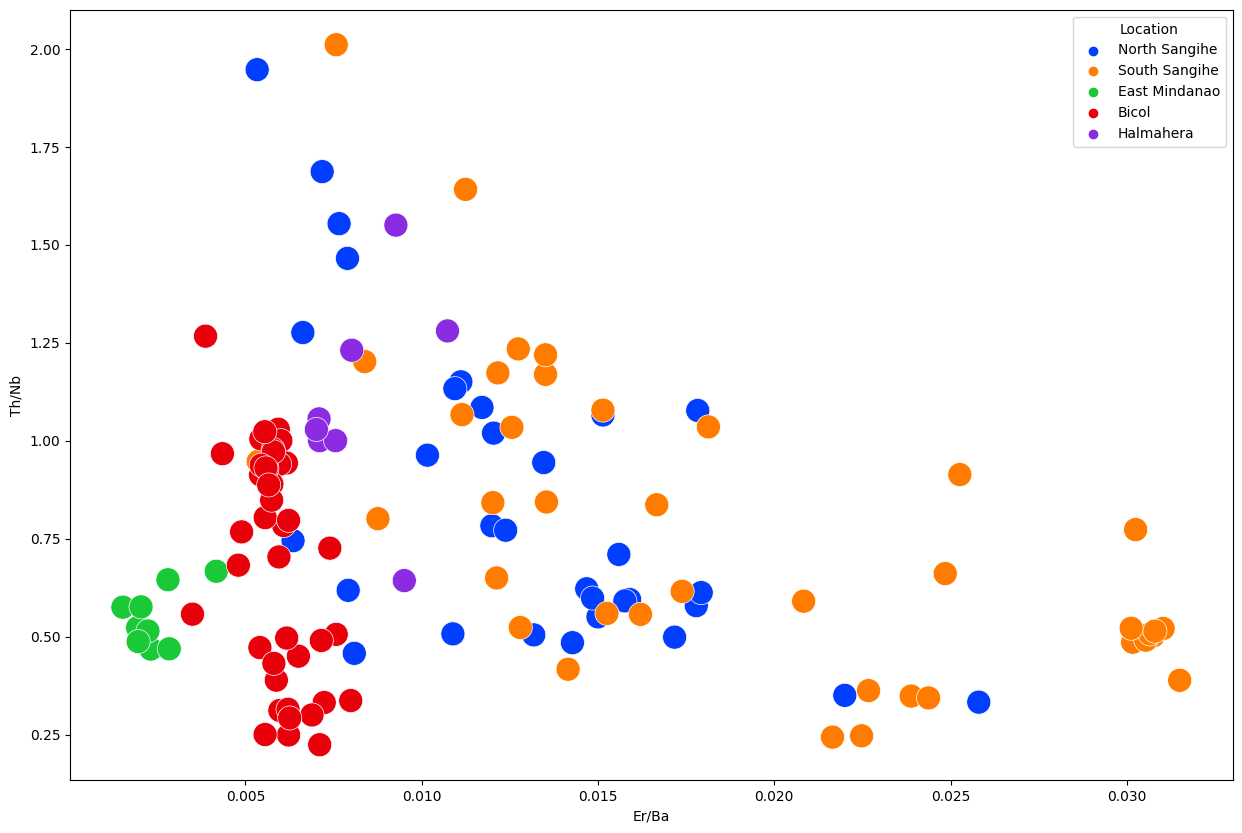

In [3]:
figk, ax = plt.subplots(figsize=(15, 10))
sns.scatterplot(data=fullDetail,
                edgecolors="black",
                linewidth=0.5,
                x="Er/Ba",
                y="Th/Nb",
                s=300,
                palette='bright',
                hue="Location")

<Axes: xlabel='Sr/Rb', ylabel='Th/Nb'>

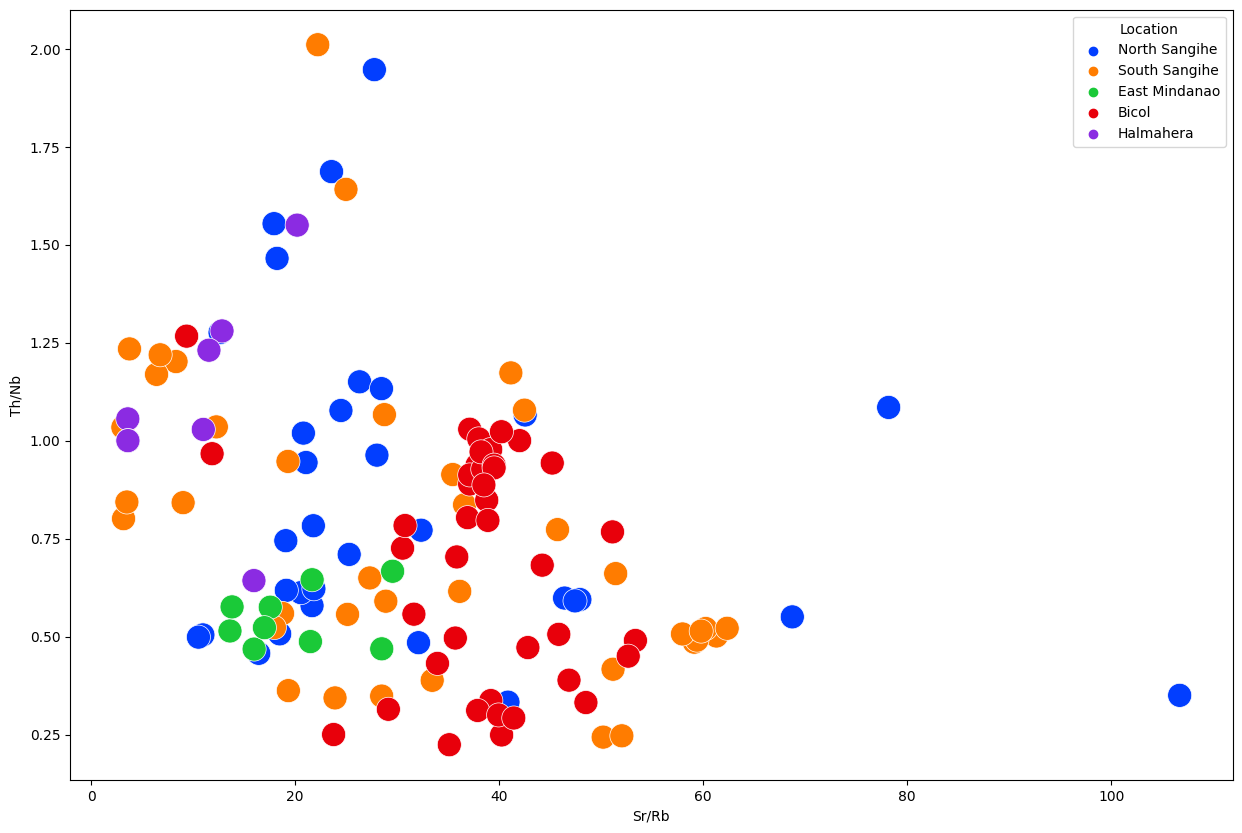

In [4]:
figk, ax = plt.subplots(figsize=(15, 10))
sns.scatterplot(data=fullDetail,
                edgecolors="black",
                linewidth=0.5,
                x="Sr/Rb",
                y="Th/Nb",
                s=300,
                palette='bright',
                hue="Location")

<Axes: xlabel='Er/Ba', ylabel='Sr/Rb'>

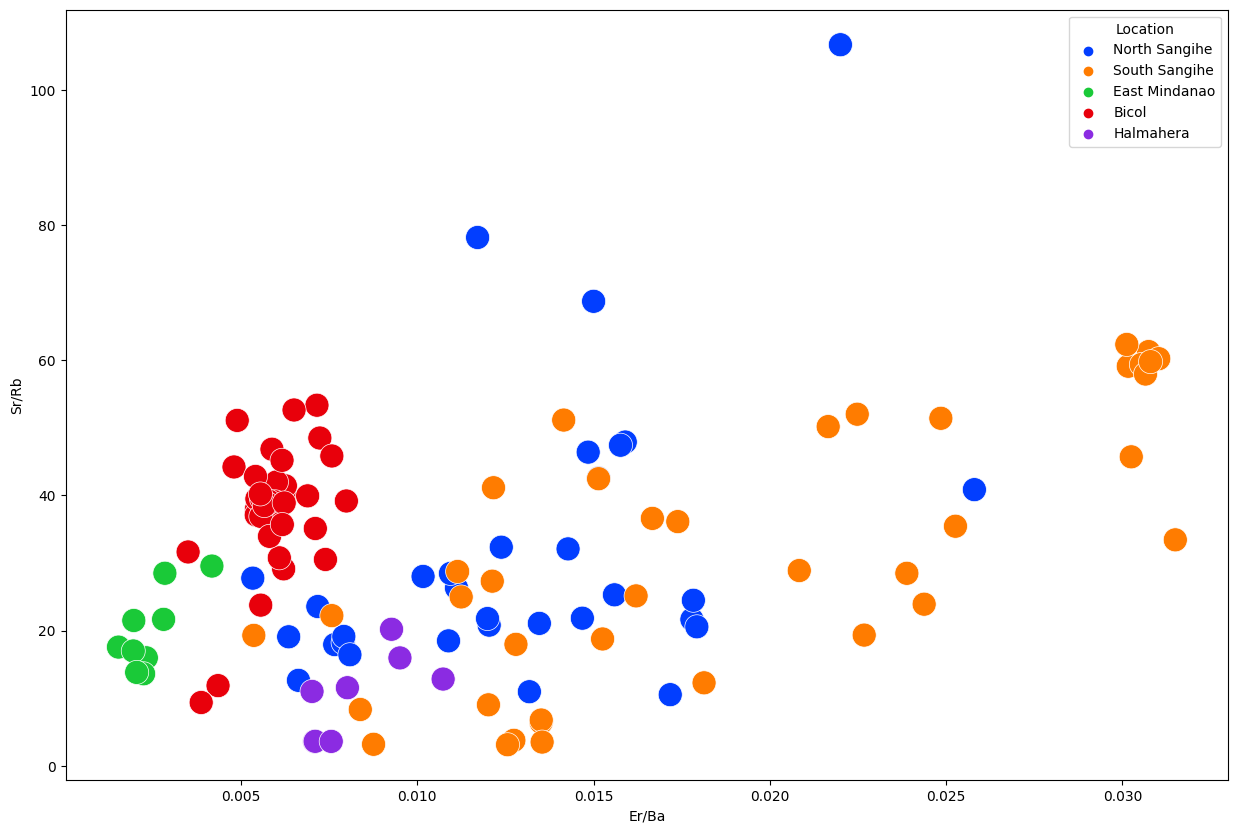

In [5]:
figk, ax = plt.subplots(figsize=(15, 10))
sns.scatterplot(data=fullDetail,
                edgecolors="black",
                linewidth=0.5,
                x="Er/Ba",
                y="Sr/Rb",
                s=300,
                palette='bright',
                hue="Location")

In [6]:
# Define a mapping of Location categories to symbols
location_symbol_mapping = {
    'Sangihe': 'circle',
    'East Philippine': 'cross',
    'Halmahera': 'square',
}

location_color_mapping = {
    'North Sangihe': '#023EFF',
    'South Sangihe': '#FF7C00',
    'Bicol': '#E8000B',
    'East Mindanao': '#1AC938',
    'Halmahera': '#8B2BE2',
}

# Apply the mapping to the 'Location' column
fullDetail['location_symbol'] = fullDetail['Island Arc'].map(location_symbol_mapping)

# Apply the color mapping to the 'Location' column
fullDetail['location_color'] = fullDetail['Location'].map(location_color_mapping)

# Create 3D scatter plot
fig = go.Figure()

# Scatter plot for IC1, IC2, and IC3 with different symbols based on "Location"
fig.add_trace(go.Scatter3d(
    x=fullDetail['Er/Ba'],
    y=fullDetail['Sr/Rb'],
    z=fullDetail['Nb/Th'],
    mode='markers',
    marker=dict(
        size=8,
        color=fullDetail['location_color'],  # Color by 'Location'
        colorscale='rdylbu',  # Color scale
        opacity=0.8,
        symbol=fullDetail['location_symbol'],  # Use mapped symbols for locations
    ),
    text=fullDetail['Location'],  # Text when hovering over points
    hoverinfo='text',
    name='Data Points',  # Name for the legend
))

# Customize layout with legend
fig.update_layout(
    scene=dict(
        xaxis_title='Er/Ba',
        yaxis_title='Sr/Rb',
        zaxis_title='Th/Nb',
    ),
    margin=dict(l=0, r=0, b=0, t=0),
    hovermode='closest',
    legend=dict(
        title='Legend',
        x=0.02, y=0.98,
        bgcolor='rgba(255, 255, 255, 0.8)',
    ),
    showlegend=False,
)

<Axes: xlabel='Ba/Nb', ylabel='Nb/Zr'>

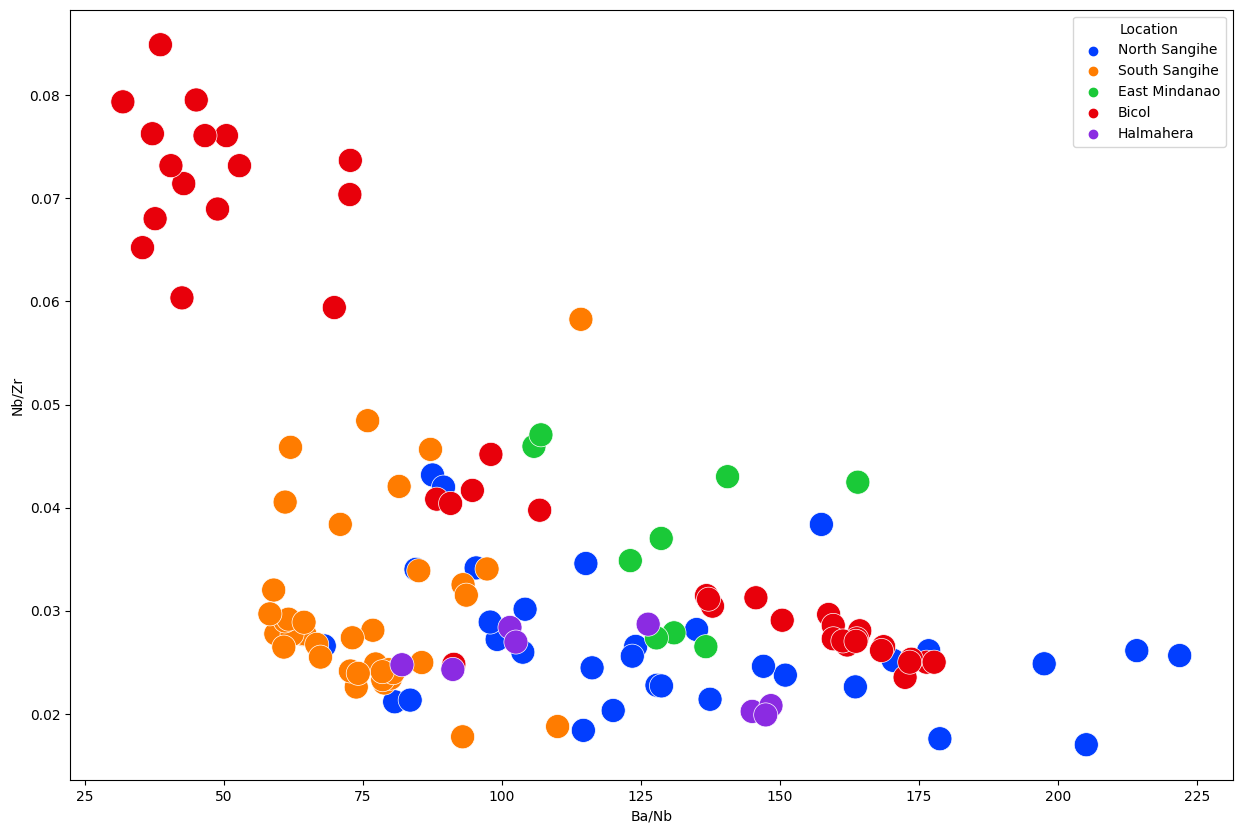

In [7]:
figm, ax = plt.subplots(figsize=(15, 10))
sns.scatterplot(data=fullDetail,
                edgecolors="black",
                linewidth=0.5,
                x="Ba/Nb",
                y="Nb/Zr",
                s=300,
                palette='bright',
                hue="Location")

<Axes: xlabel='Th/Nb', ylabel='Nb/Zr'>

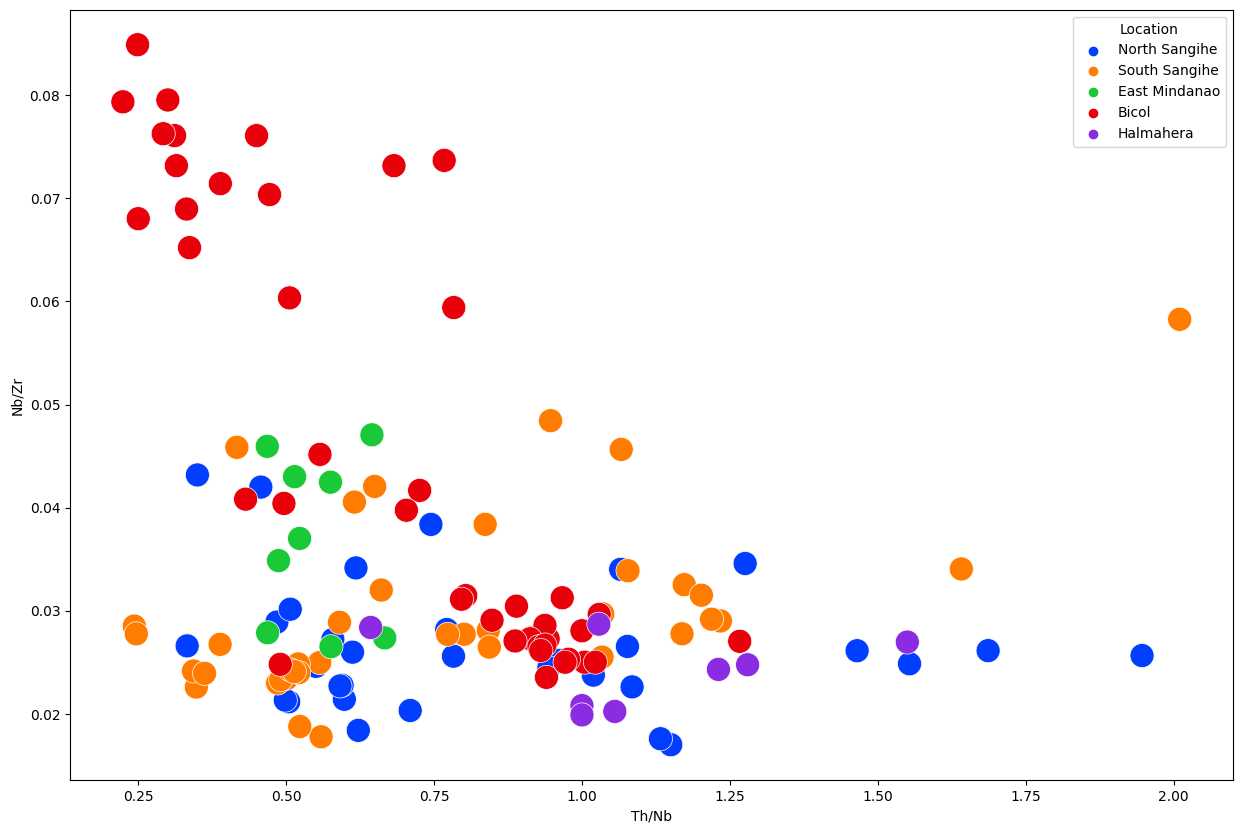

In [8]:
fign, ax = plt.subplots(figsize=(15, 10))
sns.scatterplot(data=fullDetail,
                edgecolors="black",
                linewidth=0.5,
                x="Th/Nb",
                y="Nb/Zr",
                s=300,
                palette='bright',
                hue="Location")

<Axes: xlabel='Th/Nb', ylabel='Ba/Nb'>

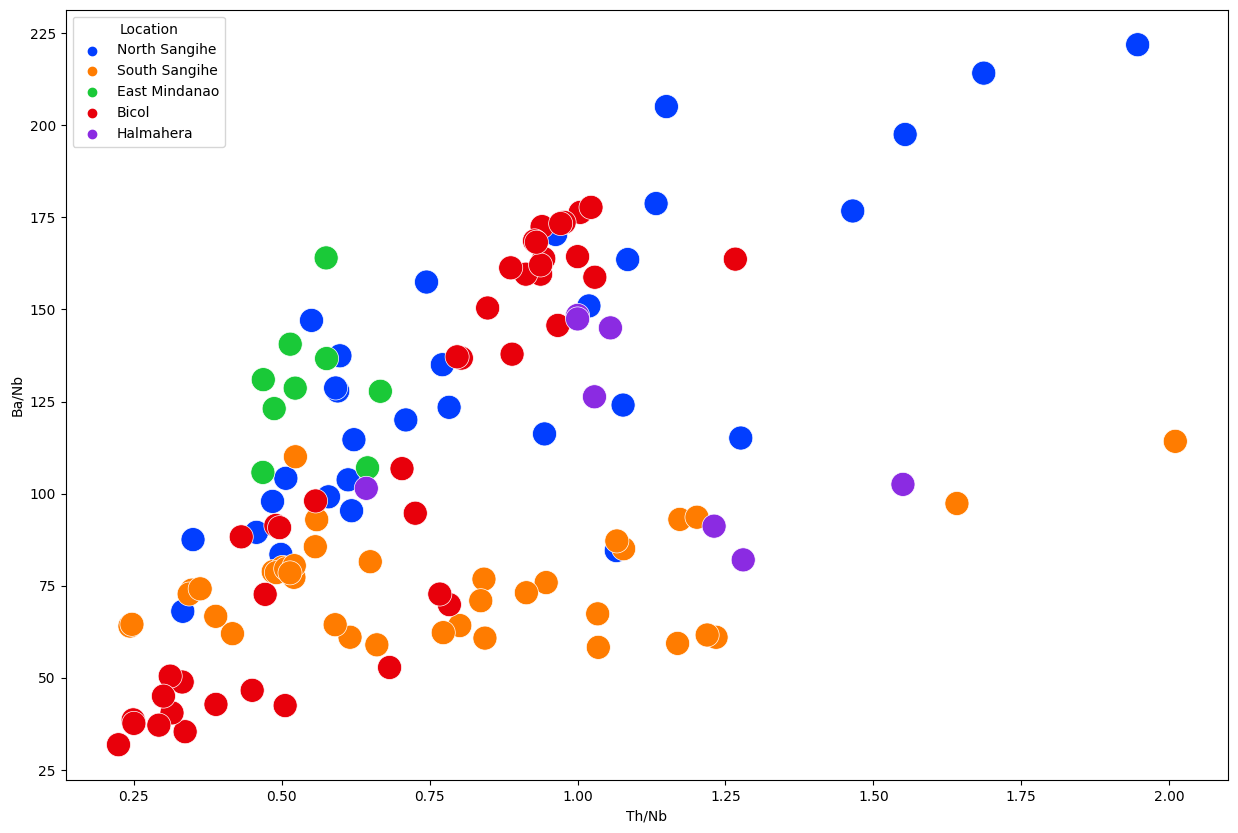

In [9]:
fign, ax = plt.subplots(figsize=(15, 10))
sns.scatterplot(data=fullDetail,
                edgecolors="black",
                linewidth=0.5,
                x="Th/Nb",
                y="Ba/Nb",
                s=300,
                palette='bright',
                hue="Location")

In [10]:
def preprocessing(df):
    
#     df = df[df['SiO2'] < 65]
    
    # define list
    elements = [
        "Sr", "Rb", "Ba", "La", 
        "Ce", "Eu", "Er", "Yb", 
        "Th", "Nb", "Zr", "Y"
    ]
    
    frame = [
        "Location", "Longitude", "Latitude", "AGE", "Sample Name", "Island Arc", "SiO2"
    ]
    
    # Separate the data based on the variable
    elementsData = df[elements]
    frameData = df[frame]
    
    # change inf value to nan 
    elementData = elementsData.copy()
    elementData.loc[:, :] = elementData.loc[:, :].replace([np.inf, -np.inf], np.nan).replace([0], np.nan)
    
    # Drop Na value
    cleanData = elementData.dropna(axis=0)
    
    # Normalize to 1
    df_normalized = cleanData.div(cleanData.sum(axis=0), axis=1)
    
    # logratio + standardScaler transformation
    logRatioData = clr(df_normalized)
    logRatioDataframe = pd.DataFrame(data=logRatioData, columns=elements, index=df_normalized.index)

    # elimination with z-score
    data = logRatioDataframe[elements]
    zScore = np.abs(st.zscore(data))
    cleanDataZScore1 = data[(zScore < 3).all(axis=1)]
    cleanDataZScore = cleanDataZScore1
    
    # concat Z-score and frame dataframe
    concatData = pd.concat([cleanDataZScore, frameData], axis=1, join='inner')
    concatData.reset_index(drop=True, inplace=True)
    concatData.to_csv('10_rasio_trace_element.csv')
    preprocessingData = concatData[elements]
    
    return preprocessingData , concatData, frame, elements, frameData
df = pd.read_csv("/kaggle/input/geochemistry/Dataset.csv")

preprocessingData, concatData, frame, elements, frameData= preprocessing(df)
    


In [11]:
concatData

Sr        Rb        Ba        La        Ce        Eu        Er  \
0    0.376102  0.141893 -0.082295 -0.147457 -0.026834  0.387568  0.308690   
1    0.238522 -0.074072 -0.082773 -0.081290  0.030295  0.286866  0.292747   
2   -0.865814 -0.224006 -0.091250 -0.368864 -0.274089  0.221200  0.470382   
3   -0.032857 -0.227607 -0.238787 -0.044082 -0.212138  0.257825  0.490972   
4    0.240610  0.241159 -0.162665 -0.150209 -0.042985  0.314496  0.308462   
..        ...       ...       ...       ...       ...       ...       ...   
133 -0.714359  0.138724 -0.181484  0.165379  0.161060 -0.028485 -0.094079   
134 -0.171353 -0.141076 -0.229346  0.072105  0.078561  0.134601 -0.019706   
135 -0.488731 -0.004817 -0.275408 -0.039709  0.045025 -0.077697  0.080834   
136 -0.434035  0.155090 -0.159693 -0.098602  0.032151 -0.107032 -0.095104   
137 -0.082890 -0.125939 -0.119949  0.174254  0.244875  0.076469 -0.064501   

           Yb        Th        Nb        Zr         Y       Location  \
0    0.254873 -0.413153 -0.870201 -0.110410  0.181223  North Sangihe   
1    0.251508 -0.291449 -0.733261 -0.007072  0.169978  North Sangihe   
2    0.527006 -0.313693  0.053677  0.594235  0.271216  North Sangihe   
3    0.485924 -0.516492 -0.490717  0.090548  0.437412  North Sangihe   
4    0.262250 -0.307910 -0.644128 -0.218868  0.159787  North Sangihe   
..        ...       ...       ...       ...       ...            ...   
133  0.037949  0.784148 -0.340112  0.059147  0.012113      Halmahera   
134 -0.000321  0.431778 -0.323646 -0.025183  0.193586      Halmahera   
135  0.058451  0.417464 -0.146565  0.237111  0.194043      Halmahera   
136  0.005134  0.388129 -0.136680  0.265484  0.185159      Halmahera   
137  0.044833  0.498209 -0.950363  0.023572  0.281431      Halmahera   

     Longitude  Latitude               AGE         Sample Name Island Arc  \
0      125.800     4.500  PLIOCENE [16735]  s_PJ-40-78 [16735]    Sangihe   
1      125.700     4.233  PLIOCENE [16735]  s_PJ-43-78 [16735]    Sangihe   
2      125.716     3.866  PLIOCENE [16735]  s_PJ-45-78 [16735]    Sangihe   
3      125.583     3.783  PLIOCENE [16735]    s_PBUANG [16735]    Sangihe   
4      125.583     3.783  PLIOCENE [16735]   s_PJ-5-78 [16735]    Sangihe   
..         ...       ...               ...                 ...        ...   
133    127.330     0.800               NaN        s_GL [25001]  Halmahera   
134    127.350     0.300               NaN       s_MK1 [25001]  Halmahera   
135    127.350     0.300               NaN       s_MK2 [25001]  Halmahera   
136    127.350     0.300               NaN       s_MK3 [25001]  Halmahera   
137    127.350     0.300               NaN       s_MK4 [25001]  Halmahera   

     SiO2  
0     NaN  
1     NaN  
2     NaN  
3    55.6  
4     NaN  
..    ...  
133  56.6  
134  50.0  
135  53.3  
136  55.8  
137  50.0  

[138 rows x 19 columns]

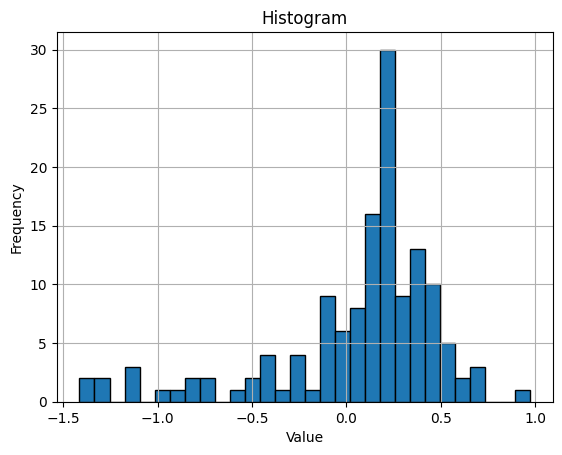

In [12]:
concatData['Sr'].hist(bins=30, edgecolor='k')
plt.title('Histogram')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

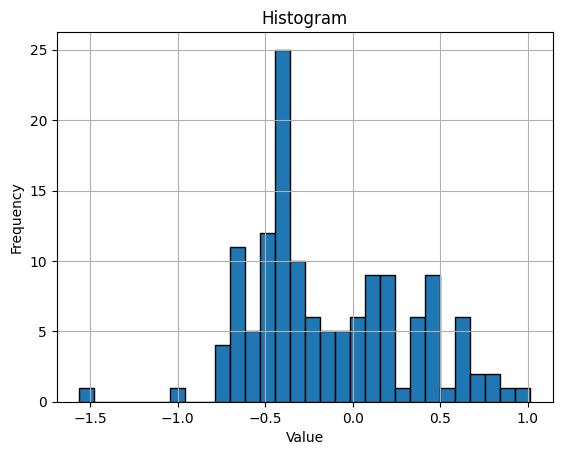

In [13]:
concatData['Rb'].hist(bins=30, edgecolor='k')
plt.title('Histogram')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

## Principal Component Analysis

### Fitting

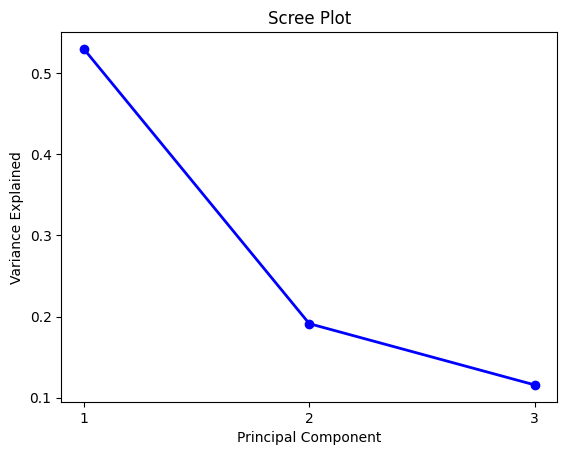

Principal Components: 
 [[0.06997157 0.3056296  0.31649996 0.19849478 0.09197023 0.30298761
  0.42626121 0.39586293 0.37681493 0.2171316  0.05141531 0.36287308]
 [0.75606402 0.39295893 0.13473003 0.16574894 0.12999734 0.12317309
  0.18412304 0.21445026 0.23680108 0.05120575 0.20065137 0.1319345 ]
 [0.1750338  0.39440763 0.06185747 0.07163428 0.10249042 0.14948484
  0.06529252 0.03157935 0.16214377 0.81043809 0.23518425 0.16830174]]
Explained Variance Ratio: 
 [0.52975966 0.19121722 0.11572562]
Loading Vectors: 
 [[-0.06422245 -0.41691537  0.07508661]
 [ 0.28051797  0.21668882  0.16919436]
 [ 0.29049518 -0.074294    0.02653584]
 [ 0.18218573 -0.09139872  0.03072992]
 [ 0.08441362 -0.07168426  0.0439667 ]
 [-0.27809305 -0.06792117  0.06412653]
 [-0.39123805  0.10153072  0.02800941]
 [-0.36333741  0.11825402  0.01354702]
 [ 0.34585446  0.1305789   0.069557  ]
 [ 0.19929128 -0.02823632 -0.34766457]
 [ 0.04719084  0.11064492 -0.10089016]
 [-0.33305812  0.07275246 -0.07219867]]


In [14]:
def pc(preprocessingData, numberOfComponent, concatData, frame):
    # fitting
    pca = PCA(n_components=numberOfComponent, whiten=True)
    principalComponent = pca.fit_transform(preprocessingData)
    
    # Explained variance
    PC_values = np.arange(pca.n_components_) + 1
    plt.plot(PC_values,
             pca.explained_variance_ratio_,
             'o-',
             linewidth=2,
             color='blue')
    plt.title('Scree Plot')
    plt.xticks([x for x in range(1, numberOfComponent+1)])
    plt.xlabel('Principal Component')
    plt.ylabel('Variance Explained')
    plt.show()
    
    # Components
    principalComponents = abs(pca.components_)
    print("Principal Components: \n", principalComponents)
    
    explainedVarianceRatio = pca.explained_variance_ratio_
    print("Explained Variance Ratio: \n", explainedVarianceRatio)
    
    loadingVectors = pca.components_.T * np.sqrt(pca.explained_variance_)
    print("Loading Vectors: \n", loadingVectors)
    
    principalComponentsData = pd.DataFrame(data=principalComponent, columns=['PC1', 'PC2', 'PC3'])
    principalComponentsDataframe = pd.concat([principalComponentsData, concatData[frame]], axis=1)
    principalComponentsDataframe.to_csv(f"TraceElement_PCA_{numberOfComponent}.csv")
    
    return principalComponentsDataframe, principalComponent, loadingVectors, explainedVarianceRatio
    
numberOfComponent = 3
principalComponentsDataframe, principalComponent, loadingVectors, explainedVarianceRatio = pc(preprocessingData, numberOfComponent, concatData, frame)

### Visualisation

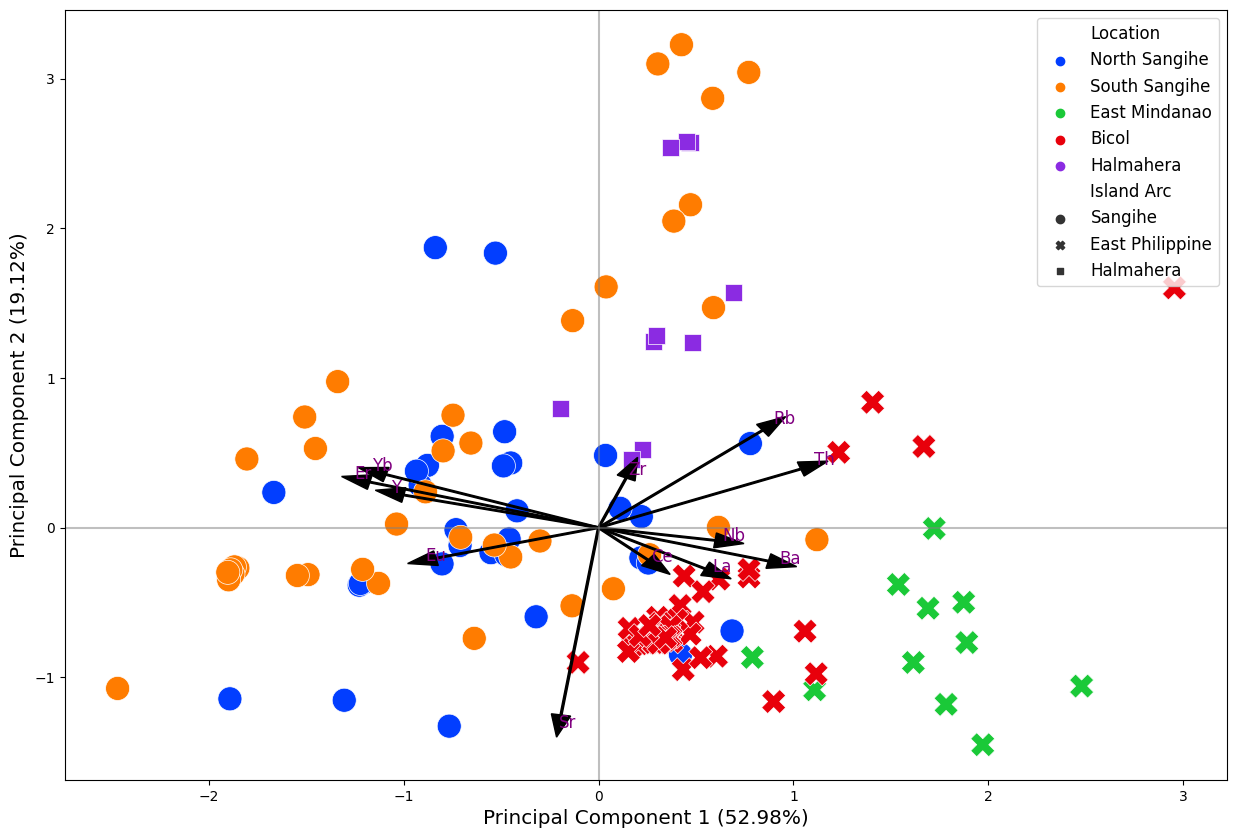

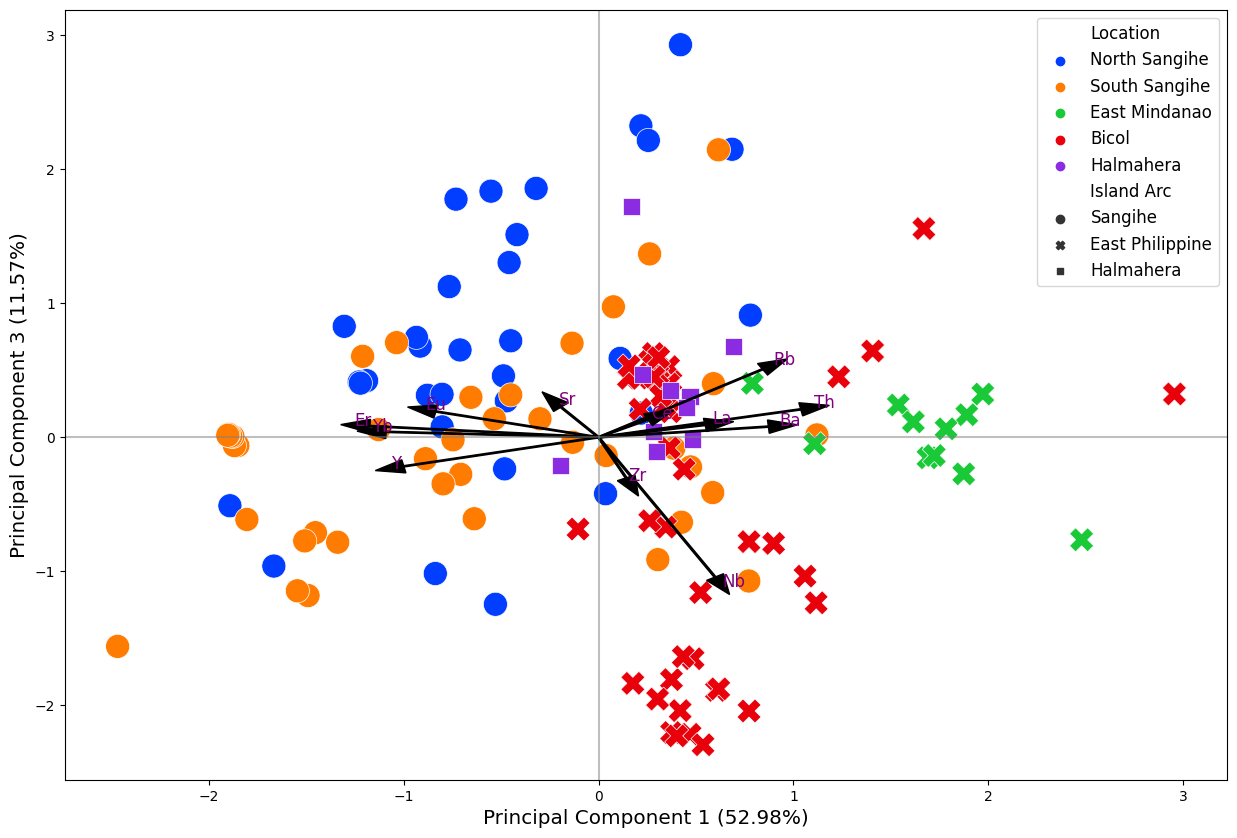

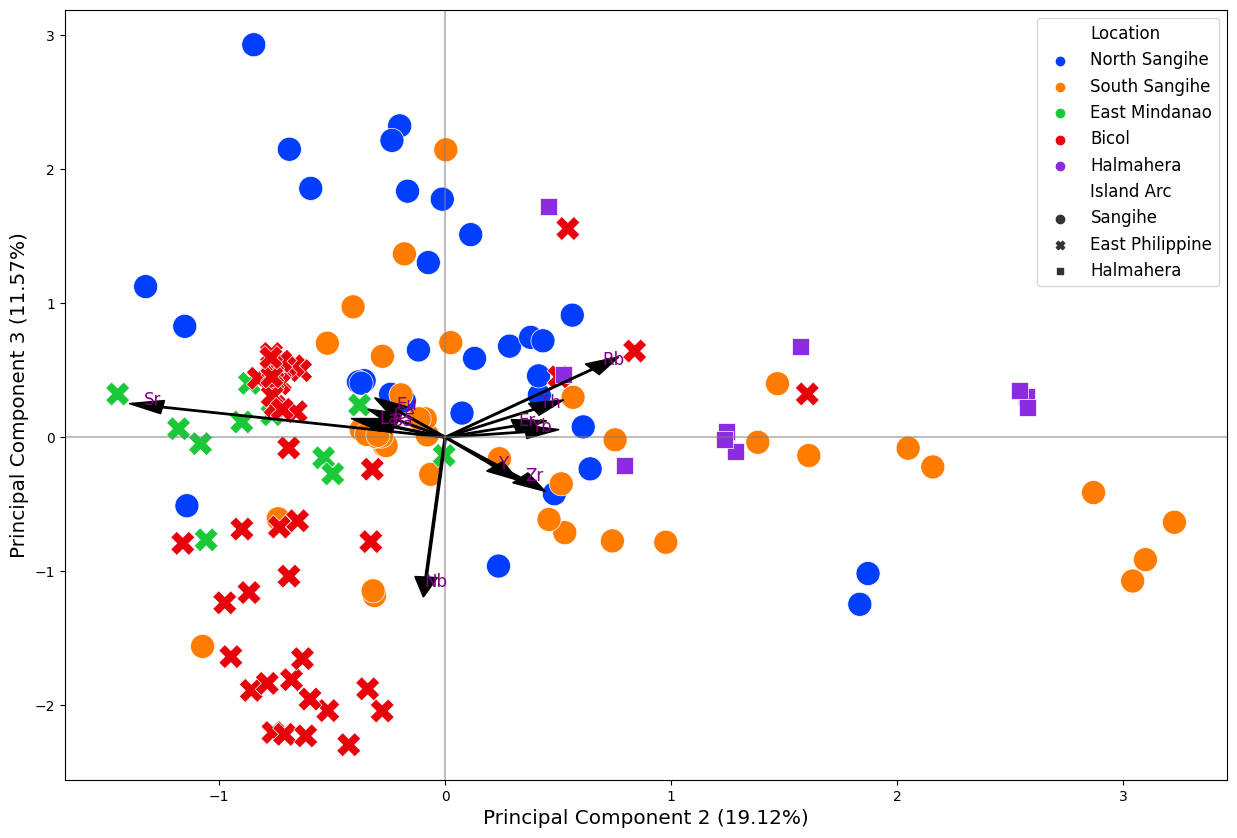

In [15]:
arrow_multiplier = 3
text_multiplier = 3.2

# arrow_multiplier = 1
# text_multiplier = 1

# PC1vsPC2
fig1, ax = plt.subplots(figsize=(15, 10))
sns.scatterplot(data=principalComponentsDataframe,
                edgecolors="black",
                linewidth=0.5,
                x="PC1",
                y="PC2",
                s=300,
                palette='bright',
                hue="Location",
                style="Island Arc")

plt.legend(fontsize="large", loc=1)
plt.xlabel(f'Principal Component 1 ({explainedVarianceRatio[0]*100:.2f}%)', fontsize="x-large")
plt.ylabel(f'Principal Component 2 ({explainedVarianceRatio[1]*100:.2f}%)', fontsize="x-large")
ax.axhline(y=0, color='gray', alpha=0.5)
ax.axvline(x=0, color='gray', alpha=0.5)
for i, feature in enumerate(elements):
    plt.arrow(0,
              0,  
              arrow_multiplier * loadingVectors[i, 0],
              arrow_multiplier * loadingVectors[i, 1],
              color='black',
              width=0.01,
              head_width=0.1)
    plt.text(text_multiplier * loadingVectors[i, 0],
             text_multiplier * loadingVectors[i, 1],
             feature,
             color="purple",
             fontsize="large")
plt.savefig(f'PCA_trace_{numberOfComponent}_1vs2.svg')

# PC1vsPC3
fig2, ax = plt.subplots(figsize=(15, 10))
sns.scatterplot(data=principalComponentsDataframe,
                edgecolors="black",
                linewidth=0.5,
                x="PC1",
                y="PC3",
                s=300,
                palette='bright',
                hue="Location",
                style="Island Arc")

plt.legend(fontsize="large", loc=1)
plt.xlabel(f'Principal Component 1 ({explainedVarianceRatio[0]*100:.2f}%)', fontsize="x-large")
plt.ylabel(f'Principal Component 3 ({explainedVarianceRatio[2]*100:.2f}%)', fontsize="x-large")
ax.axhline(y=0, color='gray', alpha=0.5)
ax.axvline(x=0, color='gray', alpha=0.5)
for i, feature in enumerate(elements):
    plt.arrow(0,
              0,  
              arrow_multiplier * loadingVectors[i, 0],
              arrow_multiplier * loadingVectors[i, 2],
              color='black',
              width=0.01,
              head_width=0.1)
    plt.text(text_multiplier * loadingVectors[i, 0],
             text_multiplier * loadingVectors[i, 2],
             feature,
             color="purple",
             fontsize="large")
plt.savefig(f'PCA_trace_{numberOfComponent}_1vs3.svg')

# PC2vsPC3
fig3, ax = plt.subplots(figsize=(15, 10))
sns.scatterplot(data=principalComponentsDataframe,
                edgecolors="black",
                linewidth=0.5,
                x="PC2",
                y="PC3",
                s=300,
                palette='bright',
                hue="Location",
                style="Island Arc")

plt.legend(fontsize="large", loc=1)
plt.xlabel(f'Principal Component 2 ({explainedVarianceRatio[1]*100:.2f}%)', fontsize="x-large")
plt.ylabel(f'Principal Component 3 ({explainedVarianceRatio[2]*100:.2f}%)', fontsize="x-large")
ax.axhline(y=0, color='gray', alpha=0.5)
ax.axvline(x=0, color='gray', alpha=0.5)
for i, feature in enumerate(elements):
    plt.arrow(0,
              0,  
              arrow_multiplier * loadingVectors[i, 1],
              arrow_multiplier * loadingVectors[i, 2],
              color='black',
              width=0.01,
              head_width=0.1)
    plt.text(text_multiplier * loadingVectors[i, 1],
             text_multiplier * loadingVectors[i, 2],
             feature,
             color="purple",
             fontsize="large")
plt.savefig(f'PCA_trace_{numberOfComponent}_2vs3.svg')

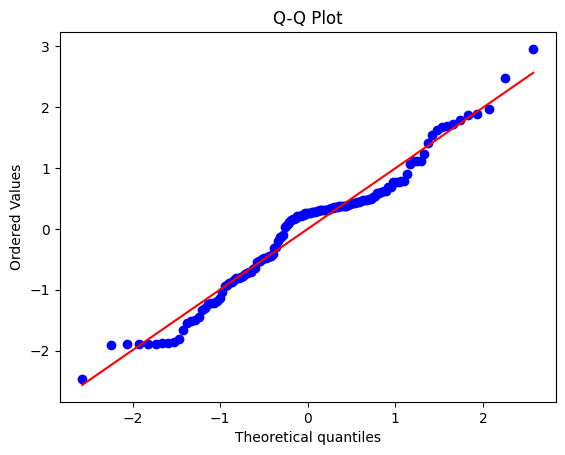

In [16]:
st.probplot(principalComponentsDataframe['PC1'], dist="norm", plot=plt)
plt.title('Q-Q Plot')
plt.show()

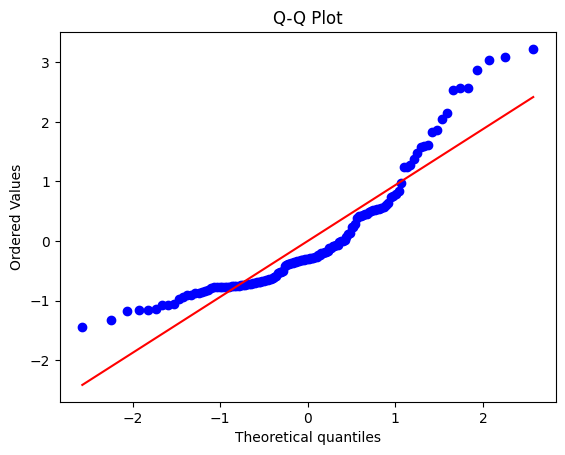

In [17]:
st.probplot(principalComponentsDataframe['PC2'], dist="norm", plot=plt)
plt.title('Q-Q Plot')
plt.show()

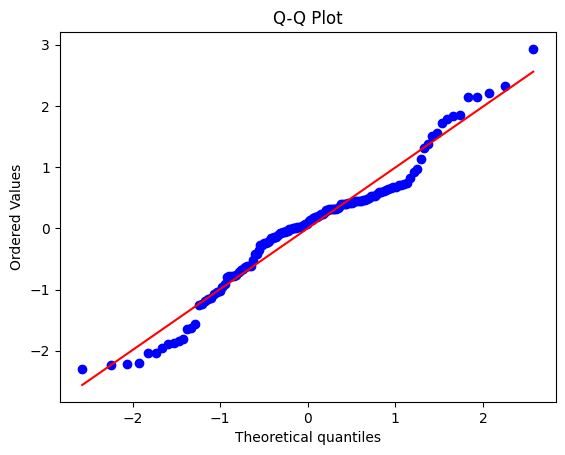

In [18]:
st.probplot(principalComponentsDataframe['PC3'], dist="norm", plot=plt)
plt.title('Q-Q Plot')
plt.show()

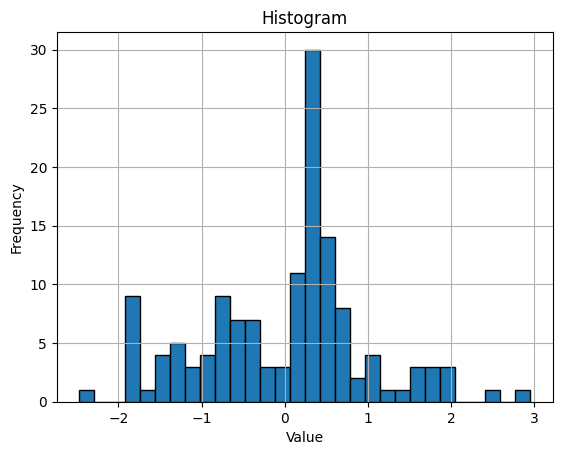

In [19]:
principalComponentsDataframe['PC1'].hist(bins=30, edgecolor='k')
plt.title('Histogram')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

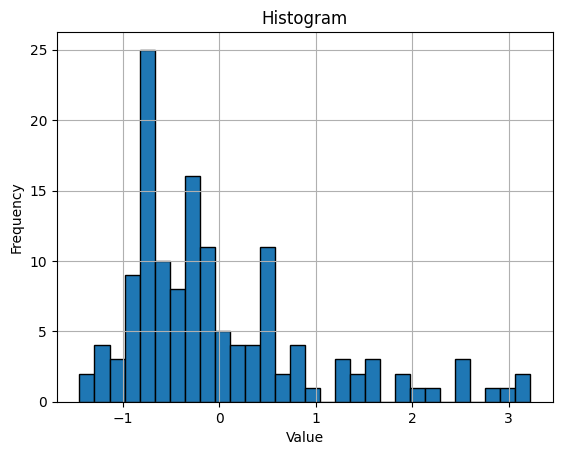

In [20]:
principalComponentsDataframe['PC2'].hist(bins=30, edgecolor='k')
plt.title('Histogram')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

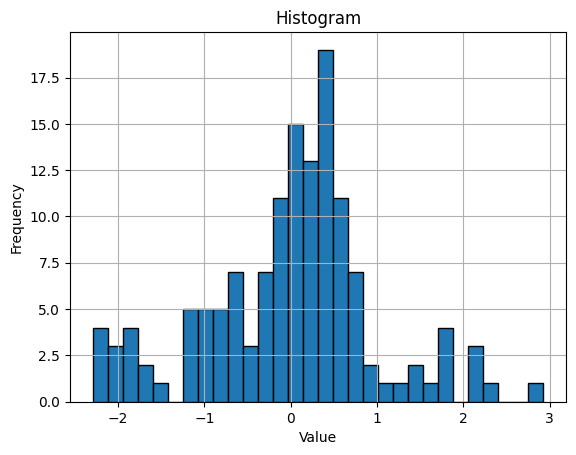

In [21]:
principalComponentsDataframe['PC3'].hist(bins=30, edgecolor='k')
plt.title('Histogram')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

## Independent Component Analysis

In [22]:
def ic(whitenedData, concatData, frame, loadingVectors):
    ica = FastICA(whiten= False, max_iter=100000, random_state=12)
    icaData = ica.fit_transform(whitenedData)
    vectorData = ica.transform(loadingVectors)
    icaIndependentComponent = pd.DataFrame(data=icaData, columns=['IC1', 'IC2', 'IC3'])
    icaDataframe = pd.concat([icaIndependentComponent, concatData[frame]], axis=1)
    
    return icaIndependentComponent, icaDataframe, vectorData

icaIndependentComponent, pcIcAndOrginal, vectorData= ic(principalComponent, concatData, frame, loadingVectors)

In [23]:
vectorDataframe = pd.DataFrame(vectorData.T, columns=elements, index=['IC1', 'IC2', 'IC3'])
vectorDataframe


Sr        Rb        Ba        La        Ce        Eu        Er  \
IC1 -0.391983  0.320095  0.088587  0.016668 -0.019123 -0.208580 -0.122361   
IC2  0.166275  0.124597  0.286022  0.203144  0.109804 -0.199797 -0.385617   
IC3  0.047783  0.190488  0.030901  0.030731  0.042129  0.051350  0.022072   

           Yb        Th        Nb        Zr         Y  
IC1 -0.092503  0.288376  0.104699  0.125396 -0.109271  
IC2 -0.370856  0.224988  0.182059 -0.019012 -0.321607  
IC3  0.009508  0.087887 -0.342458 -0.092534 -0.077858

<Figure size 1000x600 with 0 Axes>

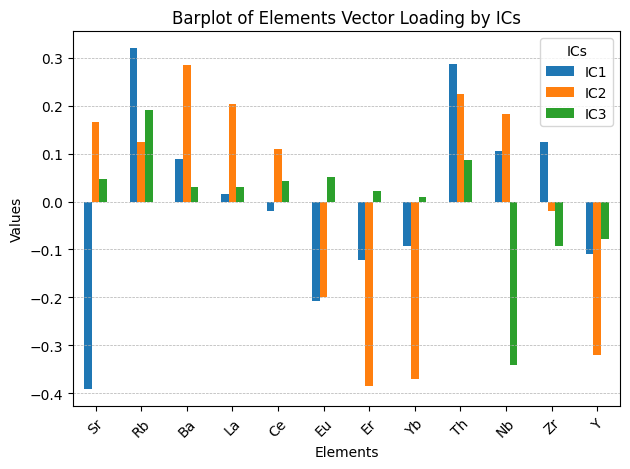

In [24]:
# Transpose the DataFrame to have elements as index
df_transposed = vectorDataframe.T

# Plotting
plt.figure(figsize=(10, 6))
df_transposed.plot(kind='bar')

# Customizing the plot
plt.title('Barplot of Elements Vector Loading by ICs')
plt.xlabel('Elements')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.legend(title='ICs', loc='upper right')
plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()

# Display the plot
plt.savefig("Barplot.png")
plt.show()

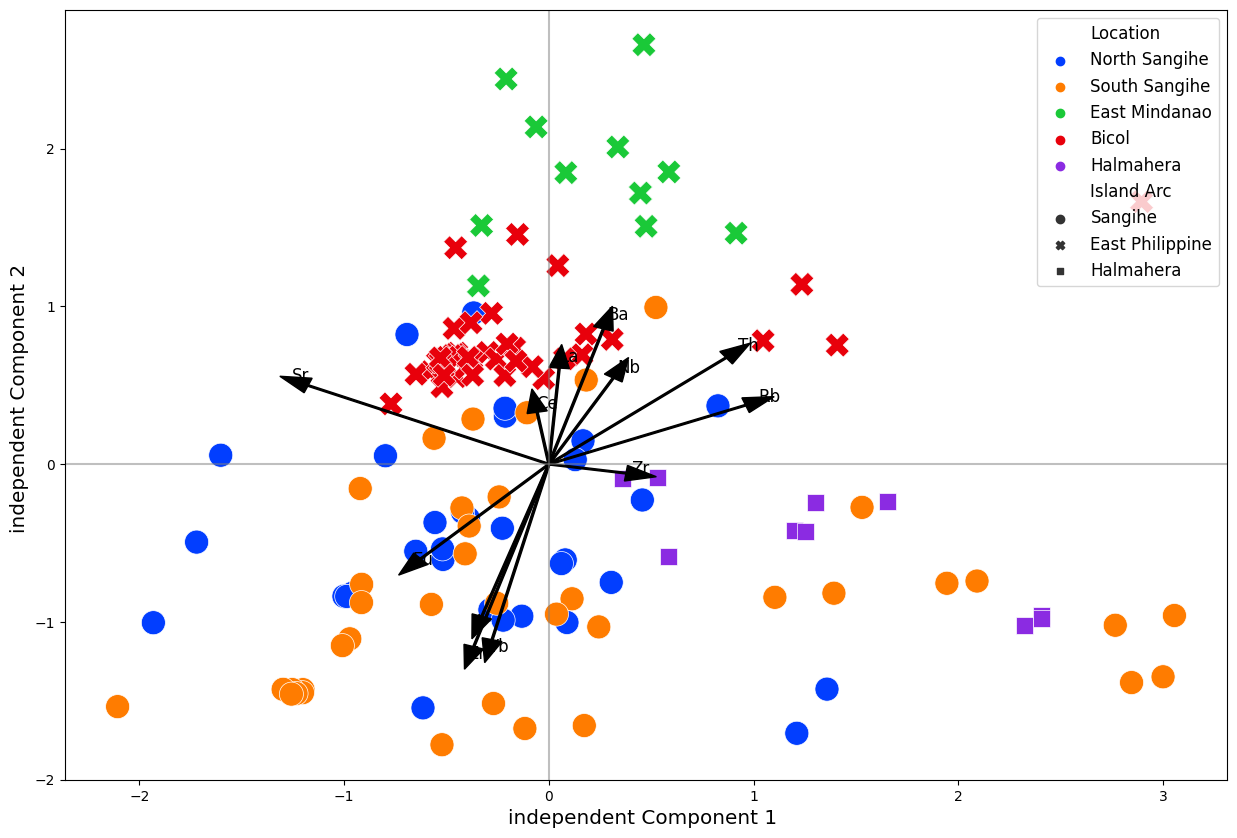

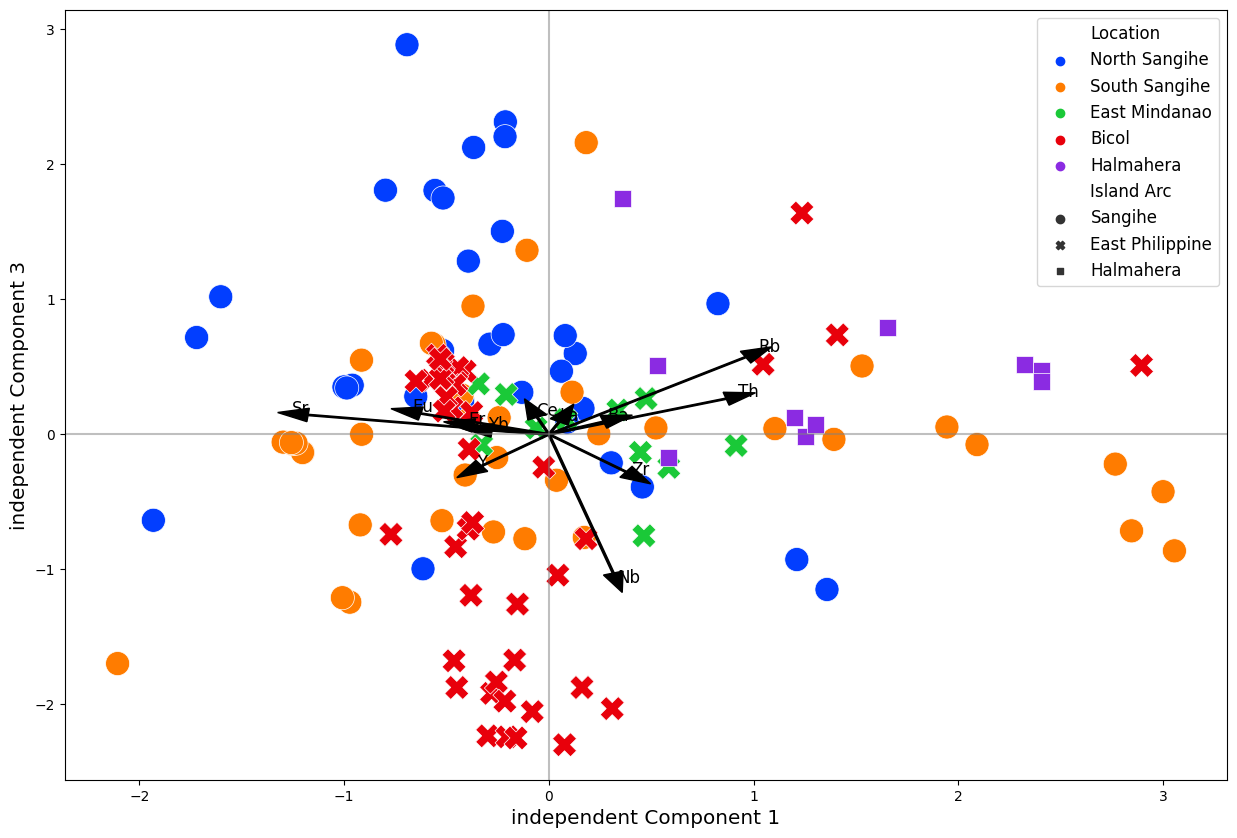

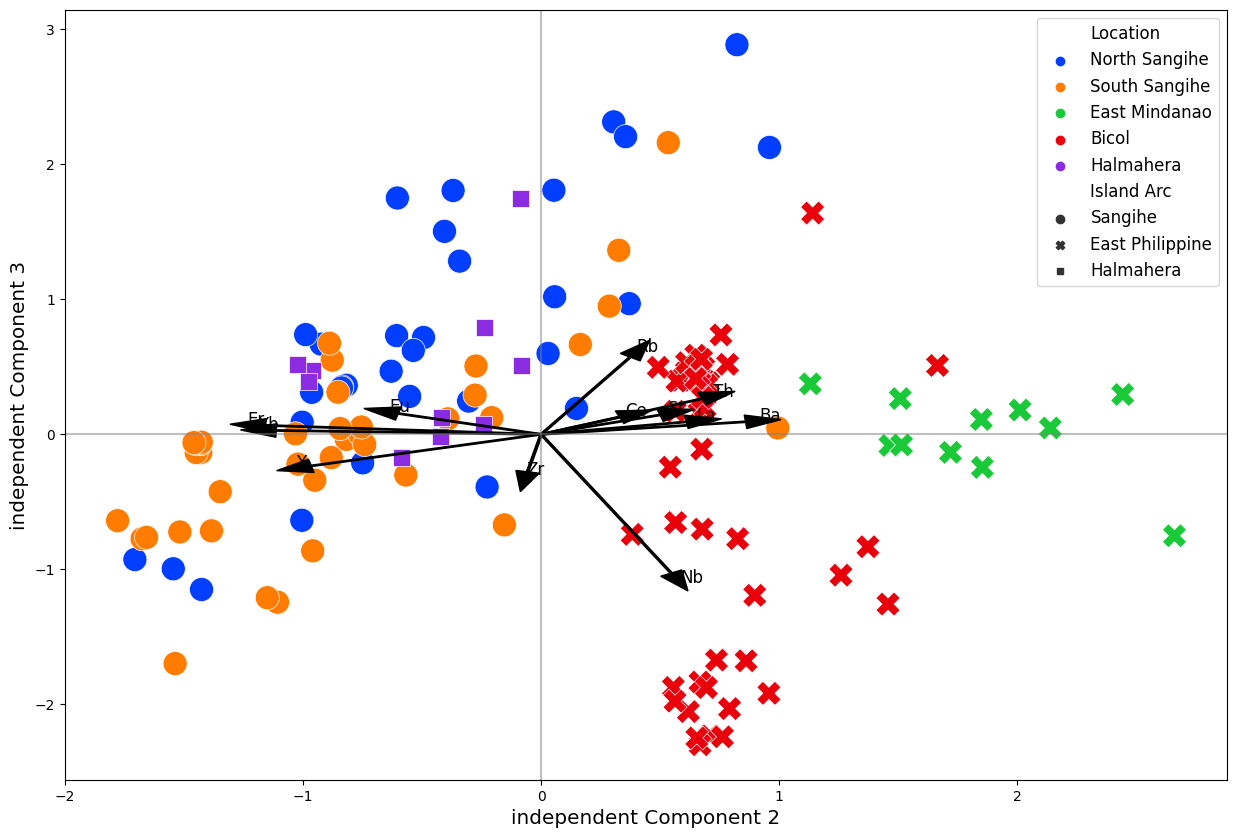

In [25]:
arrow_multiplier = 3
text_multiplier = 3.2

# IC1vsIC2
figx, ax = plt.subplots(figsize=(15, 10))
sns.scatterplot(data=pcIcAndOrginal,
                edgecolors="black",
                linewidth=0.5,
                x="IC1",
                y="IC2",
                s=300,
                palette='bright',
                hue="Location",
                style="Island Arc")
plt.legend(fontsize="large", loc=1)
plt.xlabel(f'independent Component 1 ', fontsize="x-large")
plt.ylabel(f'independent Component 2 ', fontsize="x-large")
for i, feature in enumerate(elements):
    plt.arrow(0,
              0,  
              arrow_multiplier * vectorData[i, 0],
              arrow_multiplier * vectorData[i, 1],
              color='black',
              width=0.01,
              head_width=0.1)
    plt.text(text_multiplier * vectorData[i, 0],
             text_multiplier * vectorData[i, 1],
             feature,
             fontsize="large")
ax.axhline(y=0, color='gray', alpha=0.5)
ax.axvline(x=0, color='gray', alpha=0.5)
plt.savefig(f'ICA_trace_{numberOfComponent}_1vs2.svg')
# IC1vsIC3
figy, ax = plt.subplots(figsize=(15, 10))
sns.scatterplot(data=pcIcAndOrginal,
                edgecolors="black",
                linewidth=0.5,
                x="IC1",
                y="IC3",
                s=300,
                palette='bright',
                hue="Location",
                style="Island Arc")
plt.legend(fontsize="large", loc=1)
plt.xlabel(f'independent Component 1', fontsize="x-large")
plt.ylabel(f'independent Component 3', fontsize="x-large")
for i, feature in enumerate(elements):
    plt.arrow(0,
              0,  
              arrow_multiplier * vectorData[i, 0],
              arrow_multiplier * vectorData[i, 2],
              color='black',
              width=0.01,
              head_width=0.1)
    plt.text(text_multiplier * vectorData[i, 0],
             text_multiplier * vectorData[i, 2],
             feature,
             fontsize="large")
ax.axhline(y=0, color='gray', alpha=0.5)
ax.axvline(x=0, color='gray', alpha=0.5)
plt.savefig(f'ICA_trace_{numberOfComponent}_1vs3.svg')
# IC2vsIC3
figz, ax = plt.subplots(figsize=(15, 10))
sns.scatterplot(data=pcIcAndOrginal,
                edgecolors="black",
                linewidth=0.5,
                x="IC2",
                y="IC3",
                s=300,
                palette='bright',
                hue="Location",
                style="Island Arc")
plt.legend(fontsize="large", loc=1)
plt.xlabel(f'independent Component 2', fontsize="x-large")
plt.ylabel(f'independent Component 3', fontsize="x-large")
for i, feature in enumerate(elements):
    plt.arrow(0,
              0,  
              arrow_multiplier * vectorData[i, 1],
              arrow_multiplier * vectorData[i, 2],
              color='black',
              width=0.01,
              head_width=0.1)
    plt.text(text_multiplier * vectorData[i, 1],
             text_multiplier * vectorData[i, 2],
             feature,
             fontsize="large")
ax.axhline(y=0, color='gray', alpha=0.5)
ax.axvline(x=0, color='gray', alpha=0.5)
plt.savefig(f'ICA_trace_{numberOfComponent}_2vs3.svg')

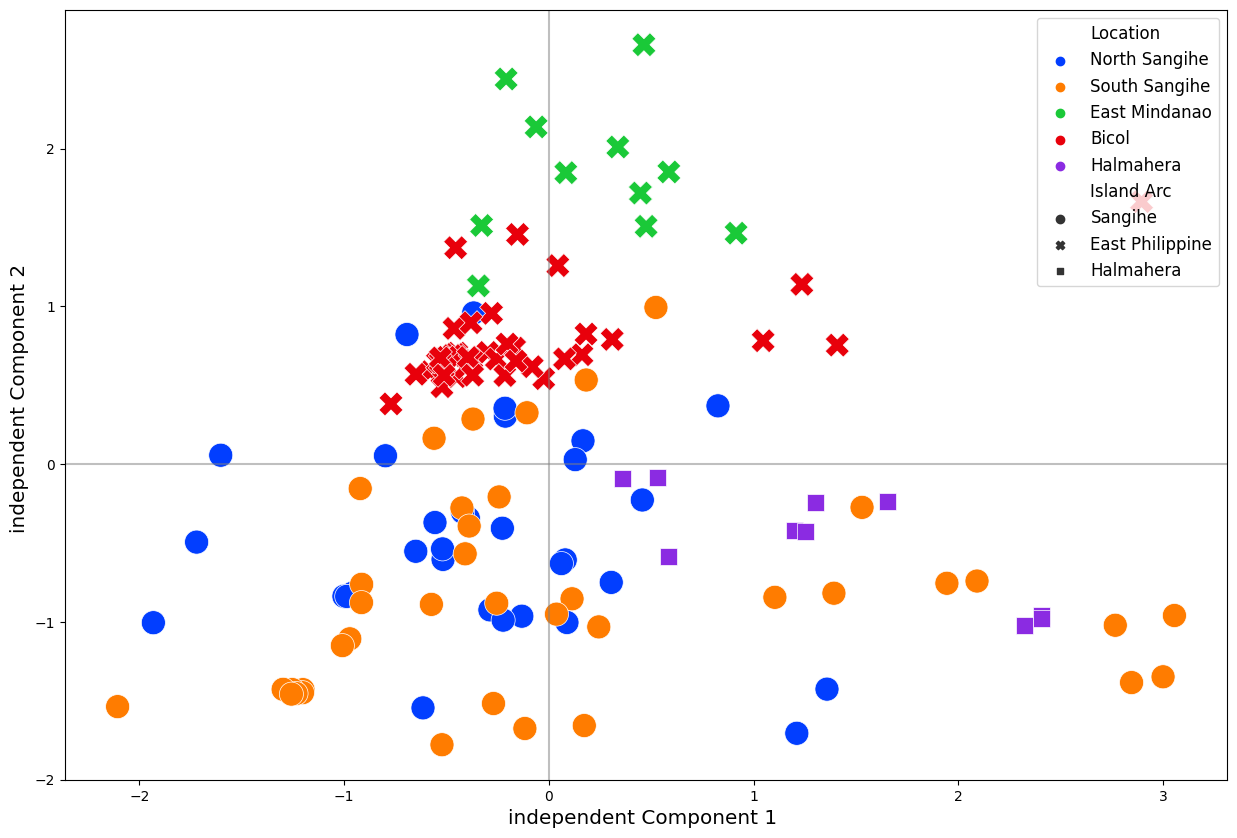

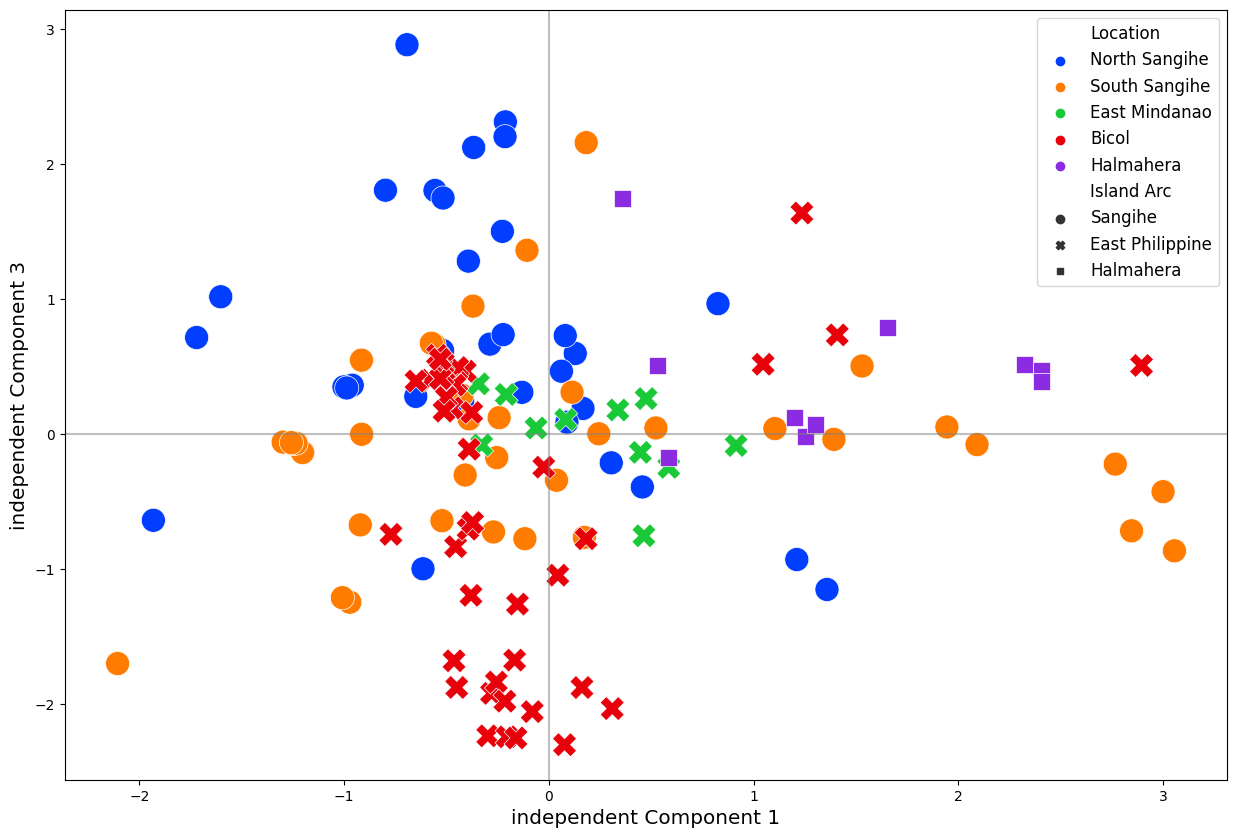

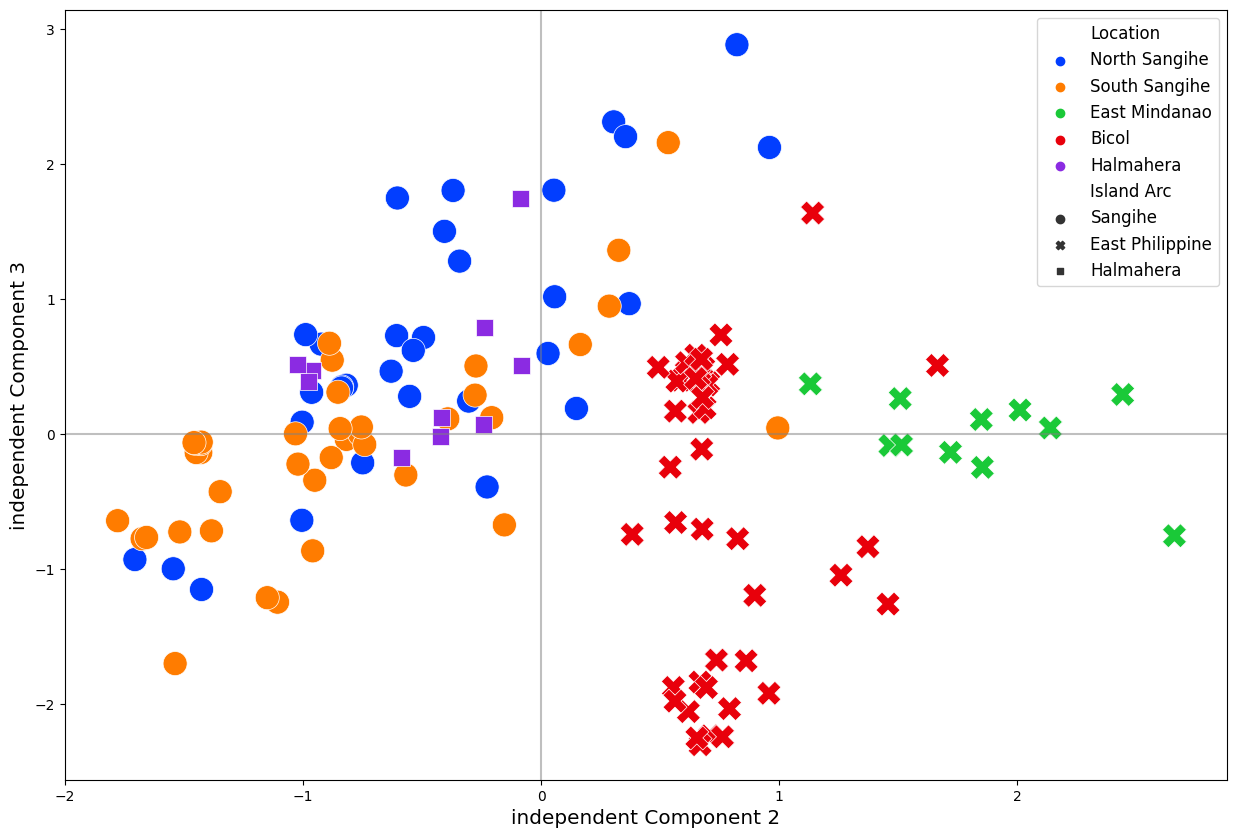

In [26]:
# IC1vsIC2
figx, ax = plt.subplots(figsize=(15, 10))
sns.scatterplot(data=pcIcAndOrginal,
                edgecolors="black",
                linewidth=0.5,
                x="IC1",
                y="IC2",
                s=300,
                palette='bright',
                hue="Location",
                style="Island Arc")
plt.legend(fontsize="large", loc=1)
plt.xlabel(f'independent Component 1 ', fontsize="x-large")
plt.ylabel(f'independent Component 2 ', fontsize="x-large")
ax.axhline(y=0, color='gray', alpha=0.5)
ax.axvline(x=0, color='gray', alpha=0.5)
plt.savefig(f'ICA_trace_{numberOfComponent}_1vs2.svg')
# IC1vsIC3
figy, ax = plt.subplots(figsize=(15, 10))
sns.scatterplot(data=pcIcAndOrginal,
                edgecolors="black",
                linewidth=0.5,
                x="IC1",
                y="IC3",
                s=300,
                palette='bright',
                hue="Location",
                style="Island Arc")
plt.legend(fontsize="large", loc=1)
plt.xlabel(f'independent Component 1', fontsize="x-large")
plt.ylabel(f'independent Component 3', fontsize="x-large")
ax.axhline(y=0, color='gray', alpha=0.5)
ax.axvline(x=0, color='gray', alpha=0.5)
plt.savefig(f'ICA_trace_{numberOfComponent}_1vs3.png')
# IC2vsIC3
figz, ax = plt.subplots(figsize=(15, 10))
sns.scatterplot(data=pcIcAndOrginal,
                edgecolors="black",
                linewidth=0.5,
                x="IC2",
                y="IC3",
                s=300,
                palette='bright',
                hue="Location",
                style="Island Arc")
plt.legend(fontsize="large", loc=1)
plt.xlabel(f'independent Component 2', fontsize="x-large")
plt.ylabel(f'independent Component 3', fontsize="x-large")
ax.axhline(y=0, color='gray', alpha=0.5)
ax.axvline(x=0, color='gray', alpha=0.5)
plt.savefig(f'ICA_trace_{numberOfComponent}_2vs3.svg')

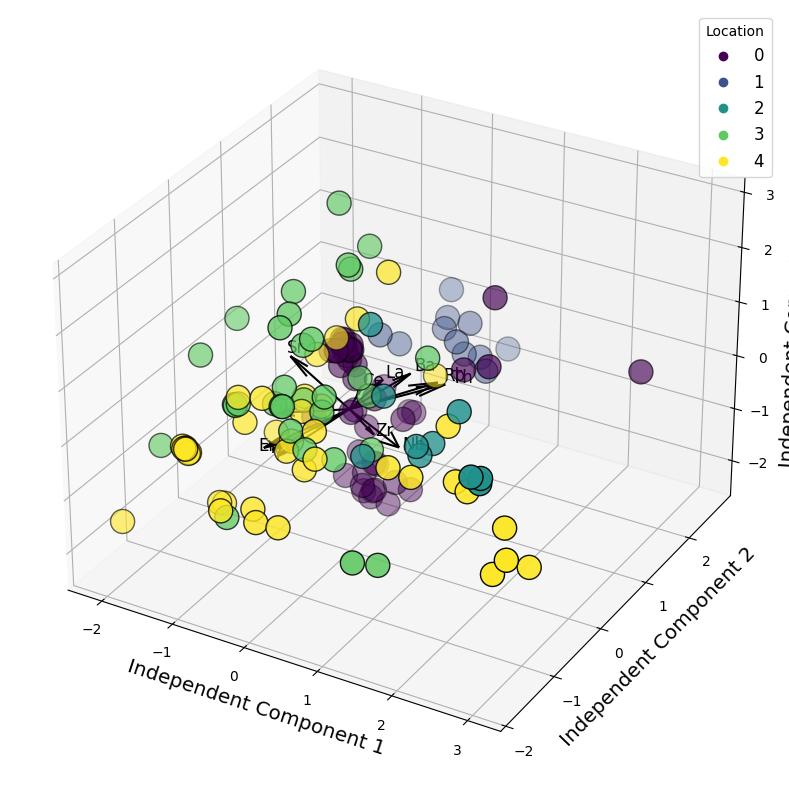

In [27]:
arrow_multiplier = 3
text_multiplier = 3.2

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for IC1, IC2, and IC3
scatter = ax.scatter(pcIcAndOrginal['IC1'],
                     pcIcAndOrginal['IC2'],
                     pcIcAndOrginal['IC3'],
                     s=300,
                     c=pcIcAndOrginal['Location'].astype('category').cat.codes, # For color based on 'Location'
                     edgecolor="black",
                     cmap='viridis')  # Use a colormap

# Plot arrows for each feature
for i, feature in enumerate(elements):
    ax.quiver(0, 0, 0,  # Start point of the arrow (origin)
              arrow_multiplier * vectorData[i, 0],  # x component
              arrow_multiplier * vectorData[i, 1],  # y component
              arrow_multiplier * vectorData[i, 2],  # z component
              color='black')
    ax.text(text_multiplier * vectorData[i, 0],
            text_multiplier * vectorData[i, 1],
            text_multiplier * vectorData[i, 2],
            feature,
            fontsize="large")

# Axis labels
ax.set_xlabel('Independent Component 1', fontsize="x-large")
ax.set_ylabel('Independent Component 2', fontsize="x-large")
ax.set_zlabel('Independent Component 3', fontsize="x-large")

# Add legend
legend = ax.legend(*scatter.legend_elements(), title="Location", fontsize="large", loc='upper right')

# Save the figure
plt.savefig(f'ICA_trace_{numberOfComponent}_3D.svg')
plt.show()

In [28]:
# Define a mapping of Location categories to symbols
location_symbol_mapping = {
    'Sangihe': 'circle',
    'East Philippine': 'cross',
    'Halmahera': 'square',
}

location_color_mapping = {
    'North Sangihe': '#023EFF',
    'South Sangihe': '#FF7C00',
    'Bicol': '#E8000B',
    'East Mindanao': '#1AC938',
    'Halmahera': '#8B2BE2',
}

# Apply the mapping to the 'Location' column
pcIcAndOrginal['location_symbol'] = pcIcAndOrginal['Island Arc'].map(location_symbol_mapping)

# Apply the color mapping to the 'Location' column
pcIcAndOrginal['location_color'] = pcIcAndOrginal['Location'].map(location_color_mapping)

arrow_multiplier = 3
text_multiplier = 3.2


# Create 3D scatter plot
fig = go.Figure()

# Scatter plot for IC1, IC2, and IC3 with different symbols based on "Location"
fig.add_trace(go.Scatter3d(
    x=pcIcAndOrginal['IC1'],
    y=pcIcAndOrginal['IC2'],
    z=pcIcAndOrginal['IC3'],
    mode='markers',
    marker=dict(
        size=8,
        color=pcIcAndOrginal['location_color'],  # Color by 'Location'
        colorscale='rdylbu',  # Color scale
        opacity=0.8,
        symbol=pcIcAndOrginal['location_symbol'],  # Use mapped symbols for locations
    ),
    text=pcIcAndOrginal['Location'],  # Text when hovering over points
    hoverinfo='text',
    name='Data Points',  # Name for the legend
))

# Add lines for each feature with a legend
for i, feature in enumerate(elements):
    fig.add_trace(go.Scatter3d(
        x=[0, arrow_multiplier * vectorData[i, 0]],  # Line from origin to scaled vector
        y=[0, arrow_multiplier * vectorData[i, 1]],  # Line from origin to scaled vector
        z=[0, arrow_multiplier * vectorData[i, 2]],  # Line from origin to scaled vector
        mode='lines',
        line=dict(color='black', width=4),  # Customize line color and width
        hoverinfo='none',  # Disable hover info for lines
        showlegend=False,
        name=feature,  # Feature name for the legend
    ))
    # Add feature names as text labels
    fig.add_trace(go.Scatter3d(
        x=[text_multiplier * vectorData[i, 0]],
        y=[text_multiplier * vectorData[i, 1]],
        z=[text_multiplier * vectorData[i, 2]],
        mode='text',
        text=[feature],
        textposition='middle right',
        showlegend=False,
    ))

# Customize layout with legend
fig.update_layout(
    scene=dict(
        xaxis_title='Independent Component 1',
        yaxis_title='Independent Component 2',
        zaxis_title='Independent Component 3',
    ),
    margin=dict(l=0, r=0, b=0, t=0),
    hovermode='closest',
    legend=dict(
        title='Legend',
        x=0.02, y=0.98,
        bgcolor='rgba(255, 255, 255, 0.8)',
    ),
    showlegend=True,
)

fig.write_html("3d_VectorLoading_scatter_plot.html")

# Show plot
display(fig)

In [29]:
import plotly.graph_objects as go

# Step 1: Define a mapping of Location categories to symbols
location_symbol_mapping = {
    'North Sangihe': 'circle',
    'South Sangihe': 'circle',
    'Bicol': 'cross',
    'East Mindanao': 'cross',
    'Halmahera': 'square',
}

location_color_mapping = {
    'North Sangihe': '#023EFF',
    'South Sangihe': '#FF7C00',
    'Bicol': '#E8000B',
    'East Mindanao': '#1AC938',
    'Halmahera': '#8B2BE2',
}

# Apply the mapping to the 'Location' column
pcIcAndOrginal['location_symbol'] = pcIcAndOrginal['Location'].map(location_symbol_mapping)

# Apply the color mapping to the 'Location' column
pcIcAndOrginal['location_color'] = pcIcAndOrginal['Location'].map(location_color_mapping)

# Verify that mapping was successful
if pcIcAndOrginal['location_color'].isnull().any():
    missing_locations = pcIcAndOrginal[pcIcAndOrginal['location_color'].isnull()]['Location'].unique()
    print(f"Warning: The following locations are missing in the color mapping: {missing_locations}")

# Step 3: Create 3D scatter plot with custom colors
fig = go.Figure()

# Scatter plot for IC1, IC2, and IC3 with different symbols and custom colors based on "Location"
fig.add_trace(go.Scatter3d(
    x=pcIcAndOrginal['IC1'],
    y=pcIcAndOrginal['IC2'],
    z=pcIcAndOrginal['IC3'],
    mode='markers',
    marker=dict(
        size=8,
        color=pcIcAndOrginal['location_color'],  # Use custom colors
        opacity=0.8,
        symbol=pcIcAndOrginal['location_symbol'],  # Use mapped symbols for locations
        # Remove colorscale since specific colors are provided
        colorscale=None,
        line=dict(width=0)  # Optional: Remove marker borders
    ),
    text=pcIcAndOrginal['Location'],  # Text when hovering over points
    hoverinfo='text',
    name='Data Points',  # Name for the legend
))

# Step 4: Customize layout with legend
fig.update_layout(
    scene=dict(
        xaxis_title='Independent Component 1',
        yaxis_title='Independent Component 2',
        zaxis_title='Independent Component 3',
    ),
    margin=dict(l=0, r=0, b=0, t=0),
    hovermode='closest',
    # If you want to display a legend, consider adding separate traces for each category
    showlegend=True,
    legend=dict(
        title='Location',
        x=0.02,
        y=0.98,
        bgcolor='rgba(255, 255, 255, 0.8)',
    ),
)

# Optional: If you want to create a legend that accurately reflects each location's color and symbol,
# it's better to create separate traces for each Location category.

# Example of creating separate traces for each Location to have a proper legend:
fig = go.Figure()

for location, color in location_color_mapping.items():
    subset = pcIcAndOrginal[pcIcAndOrginal['Location'] == location]
    fig.add_trace(go.Scatter3d(
        x=subset['IC1'],
        y=subset['IC2'],
        z=subset['IC3'],
        mode='markers',
        marker=dict(
            size=8,
            color=color,
            opacity=0.8,
            symbol=location_symbol_mapping.get(location, 'circle'),  # Default to 'circle' if not mapped
        ),
        text=subset['Location'],
        hoverinfo='text',
        name=location,
    ))

# Update layout as before
fig.update_layout(
    scene=dict(
        xaxis_title='Independent Component 1',
        yaxis_title='Independent Component 2',
        zaxis_title='Independent Component 3',
    ),
    margin=dict(l=0, r=0, b=0, t=0),
    hovermode='closest',
    legend=dict(
        title='Location',
        x=0.02,
        y=0.98,
        bgcolor='rgba(255, 255, 255, 0.8)',
    ),
)

fig.write_html("3d_scatter_plot.html")

# Show plot
fig.show()


In [30]:
pcIcAndOrginal['location_symbol'].unique()

array(['circle', 'cross', 'square'], dtype=object)

In [31]:
# Define a mapping of Location categories to symbols
location_symbol_mapping = {
    'Sangihe': 'circle',
    'East Philippine': 'square',
    'Halmahera': 'diamond',
}

# Apply the mapping to the 'Location' column
pcIcAndOrginal['location_symbol'] = pcIcAndOrginal['Island Arc'].map(location_symbol_mapping)


# Create 3D scatter plot
fig = go.Figure()

# Scatter plot for IC1, IC2, and IC3 with different symbols based on "Location"
fig.add_trace(go.Scatter3d(
    x=pcIcAndOrginal['IC1'],
    y=pcIcAndOrginal['IC2'],
    z=pcIcAndOrginal['IC3'],
    mode='markers',
    marker=dict(
        size=8,
        color=pcIcAndOrginal['Location'].astype('category').cat.codes,  # Color by 'Location'
        colorscale='rdylbu',  # Color scale
        opacity=0.8,
        symbol=pcIcAndOrginal['location_symbol'],  # Use mapped symbols for locations
    ),
    text=pcIcAndOrginal['Location'],  # Text when hovering over points
    hoverinfo='text',
    name='Data Points',  # Name for the legend
))


# Customize layout with legend
fig.update_layout(
    scene=dict(
        xaxis_title='Independent Component 1',
        yaxis_title='Independent Component 2',
        zaxis_title='Independent Component 3',
    ),
    margin=dict(l=0, r=0, b=0, t=0),
    hovermode='closest',
    legend=dict(
        title='Legend',
        x=0.02, y=0.98,
        bgcolor='rgba(255, 255, 255, 0.8)',
    ),
    showlegend=False,
)

# Show plot
display(fig)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warn

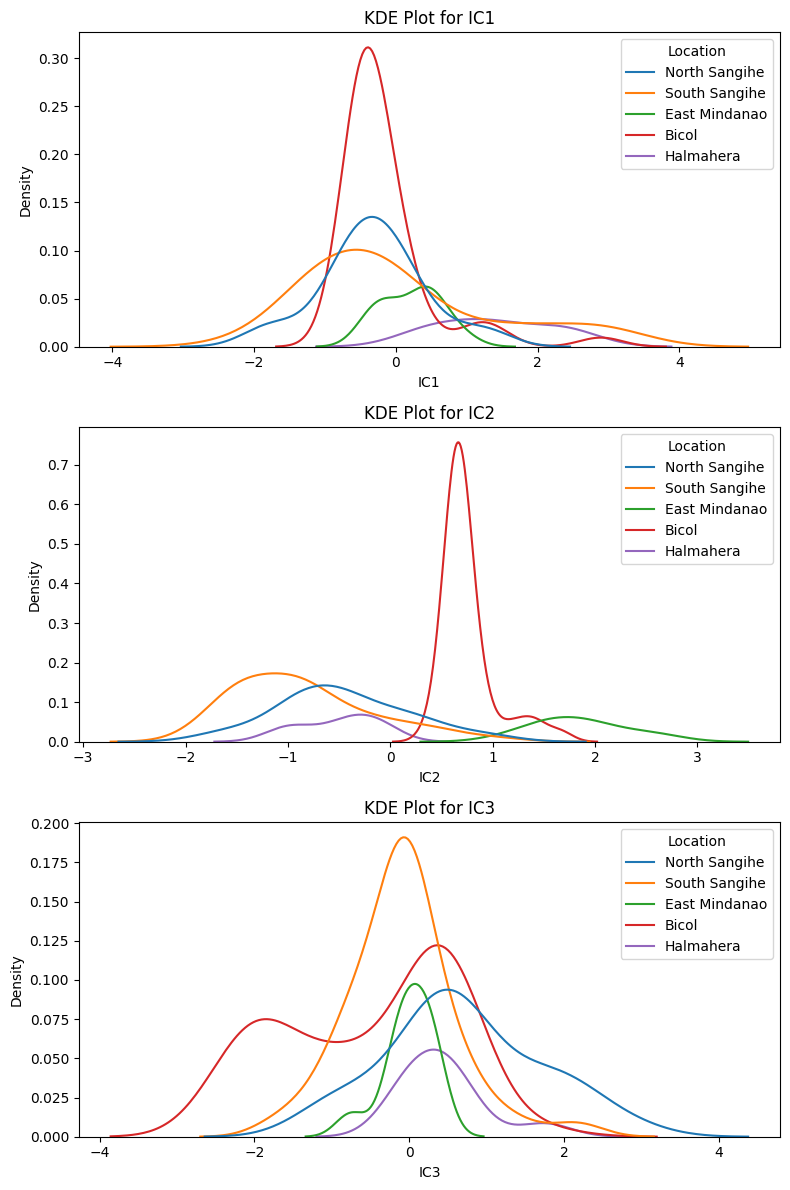

In [32]:
# Create a figure with 3 subplots arranged in a single column
fig, axes = plt.subplots(3, 1, figsize=(8, 12))

# KDE plot for IC1
sns.kdeplot(data=pcIcAndOrginal, x="IC1", hue="Location", ax=axes[0])
axes[0].set_title('KDE Plot for IC1')

# KDE plot for IC2
sns.kdeplot(data=pcIcAndOrginal, x="IC2", hue="Location", ax=axes[1])
axes[1].set_title('KDE Plot for IC2')

# KDE plot for IC3
sns.kdeplot(data=pcIcAndOrginal, x="IC3", hue="Location", ax=axes[2])
axes[2].set_title('KDE Plot for IC3')

# Adjust layout for better spacing
plt.tight_layout()

plt.savefig("kde.png")

# Show the combined figure
plt.show()

## K-Means Clustering

silhouette score GM: 0.26682629853240547


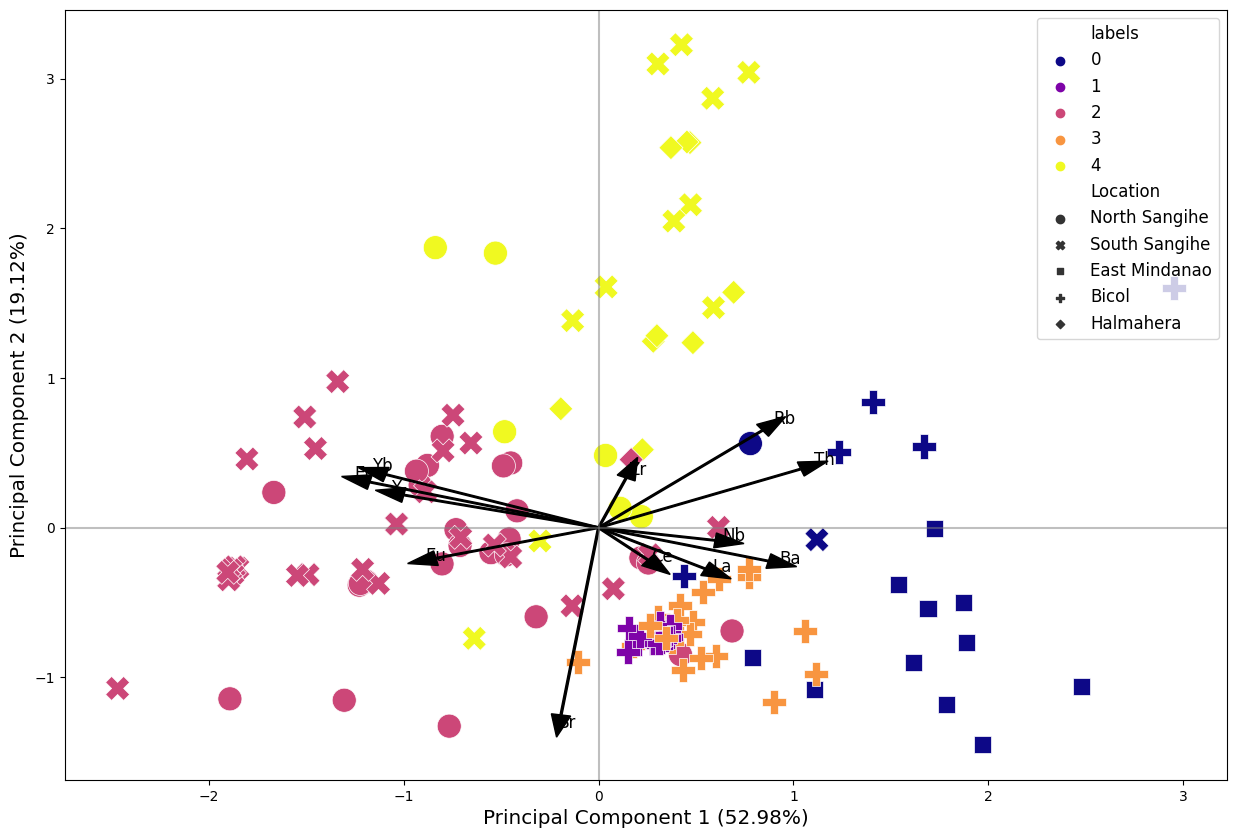

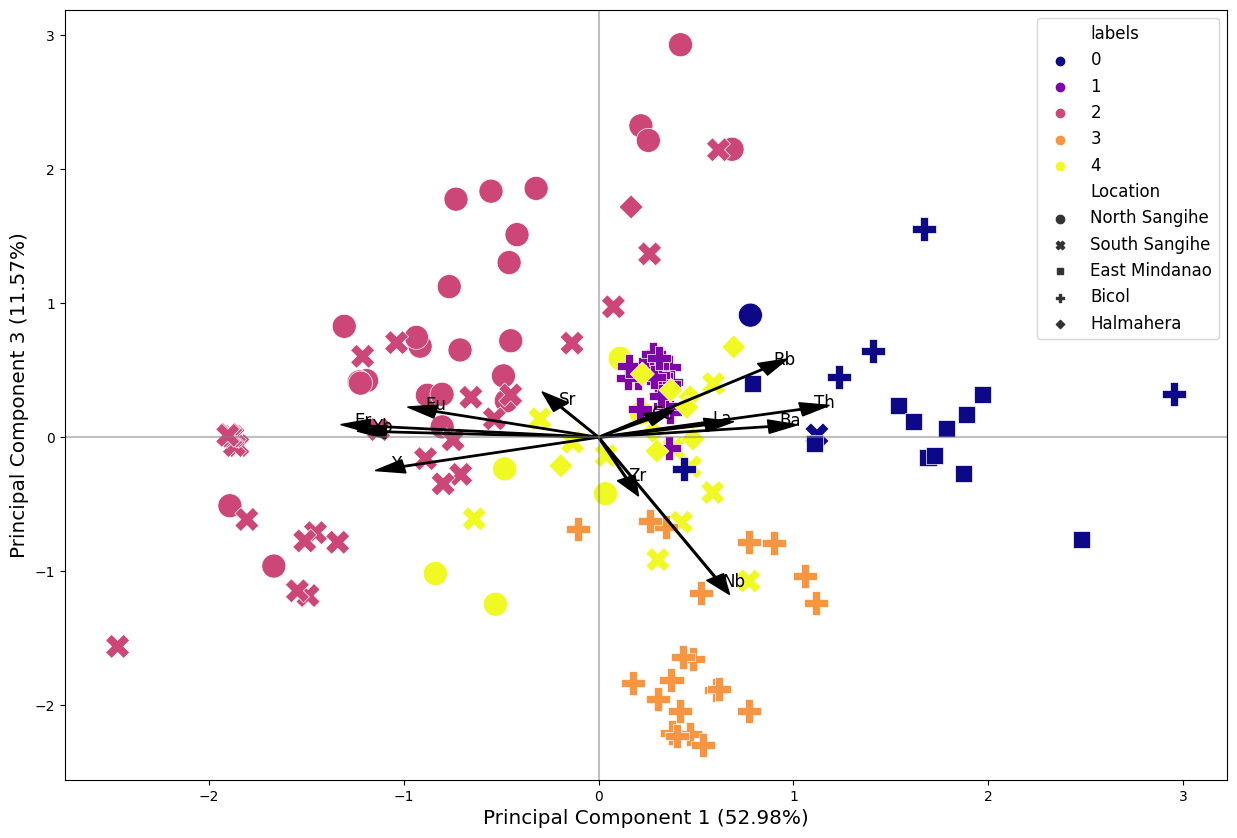

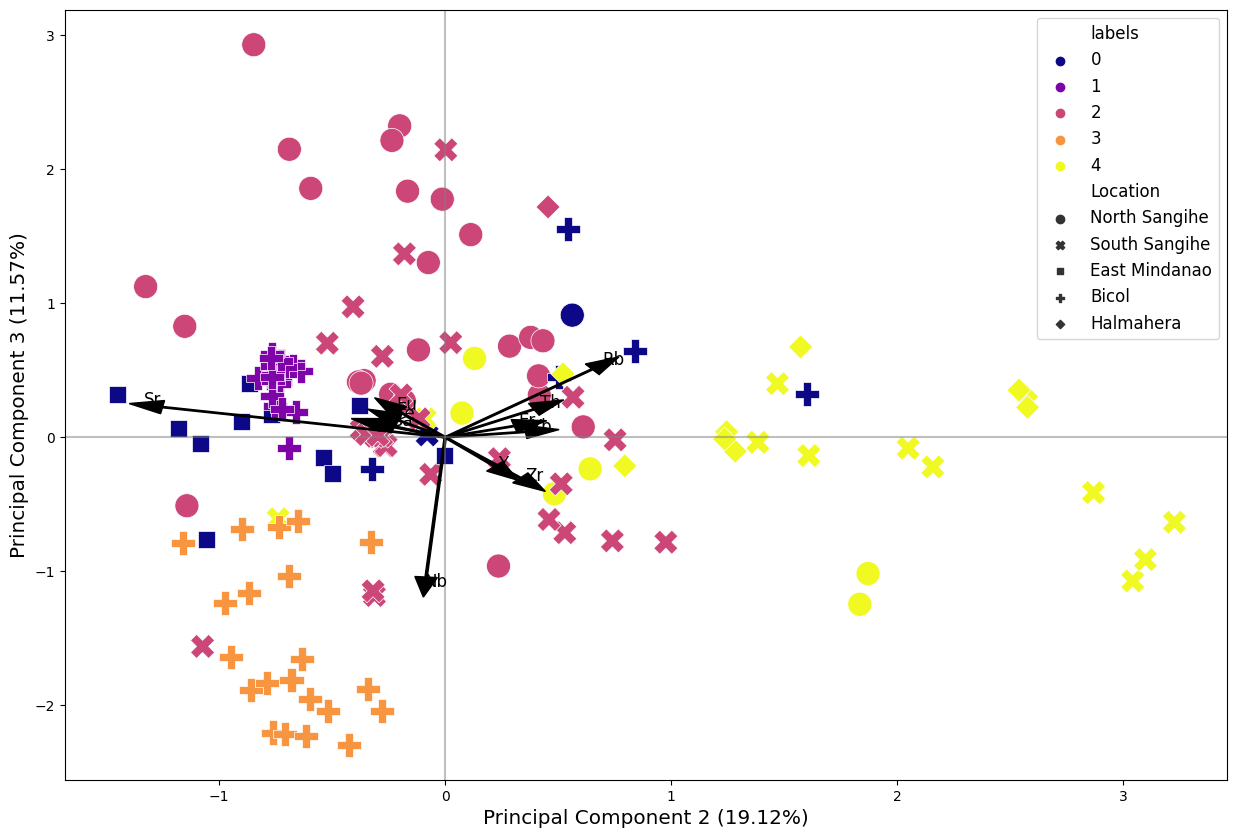

In [33]:
def gmm(principalComponentsDataframe, cluster, explainedVarianceRatio, elements, frame, loadingVectors):
    X = principalComponentsDataframe.iloc[:, 0:3].values
    dataFrame = principalComponentsDataframe[frame]
    
    gm = GaussianMixture(init_params="k-means++", n_components=cluster, random_state=12, n_init=1,covariance_type='full' )
    labels = gm.fit_predict(X)
    score = silhouette_score(X, labels)
    print(f'silhouette score GM: {score}')

    principalComponentsDataframe["labels"] = labels

# from sklearn.cluster import SpectralClustering
    
# def spectral_clustering(principalComponentsDataframe, cluster, explainedVarianceRatio, elements, frame, loadingVectors):
#     X = principalComponentsDataframe.iloc[:, 0:3].values
#     dataFrame = principalComponentsDataframe[frame]
    
#     # Initialize and fit Spectral Clustering
#     spectral = SpectralClustering(n_clusters=cluster, affinity='rbf', assign_labels='kmeans', random_state=12)
#     labels = spectral.fit_predict(X)
    
#     # Compute silhouette score
#     score = silhouette_score(X, labels)
#     print(f'silhouette score Spectral Clustering: {score}')

#     # Add labels to the dataframe
#     principalComponentsDataframe["labels"] = labels
    

# def kmc(principalComponentsDataframe, cluster, explainedVarianceRatio, ratio, frame, loadingVectors):
#     X = principalComponentsDataframe.iloc[:, 0:3].values
#     dataFrame = principalComponentsDataframe[frame]
    
#     kmeans = KMeans(init="k-means++", n_clusters=cluster, random_state=12, n_init='auto')
#     labels = kmeans.fit_predict(X)
#     score = silhouette_score(X, labels)
#     print(f'silhouette score KCA: {score}')

#     principalComponentsDataframe["labels"] = labels

# def dbscan(principalComponentsDataframe, eps, min_samples, explainedVarianceRatio, ratio, frame, loadingVectors):
#     X = principalComponentsDataframe.iloc[:, 0:3].values
#     dataFrame = principalComponentsDataframe[frame]
    
#     # Use DBSCAN instead of K-Means
#     dbscan = DBSCAN(eps=eps, min_samples=min_samples)
#     labels = dbscan.fit_predict(X)
    
#     # Silhouette score is only valid if there are more than one cluster
#     if len(set(labels)) > 1:
#         score = silhouette_score(X, labels)
#         print(f'silhouette score DBSCAN: {score}')
#     else:
#         print('Silhouette score not applicable (only one cluster found)')
    
#     principalComponentsDataframe["labels"] = labels
    
    # Plot dataset
    fig, ax = plt.subplots(figsize=(15, 10))
    sns.scatterplot(x="PC1",
                    y="PC2",
                    edgecolors="black",
                    linewidth=0.5,
                    s=300,
                    data=principalComponentsDataframe,
                    hue="labels",
                    style="Location",
                    palette="plasma")
    plt.legend(fontsize="large", loc=1)
    plt.xlabel(f'Principal Component 1 ({explainedVarianceRatio[0]*100:.2f}%)', fontsize="x-large")
    plt.ylabel(f'Principal Component 2 ({explainedVarianceRatio[1]*100:.2f}%)', fontsize="x-large")
    ax.axhline(y=0, color='gray', alpha=0.5)
    ax.axvline(x=0, color='gray', alpha=0.5)
    for i, feature in enumerate(elements):
        plt.arrow(0,
                  0,
                  3 * loadingVectors[i, 0],
                  3 * loadingVectors[i, 1],
                  color='black',
                  width=0.01,
                  head_width=0.1)
        plt.text(3.2 * loadingVectors[i, 0],
                 3.2 * loadingVectors[i, 1],
                 feature,
                 fontsize="large")
    plt.savefig(f'KMC_trace_PC1_vs_PC2_{score}.svg')

    fig2, ax = plt.subplots(figsize=(15, 10))
    sns.scatterplot(x="PC1",
                    y="PC3",
                    edgecolors="black",
                    linewidth=0.5,
                    s=300,
                    data=principalComponentsDataframe,
                    hue="labels",
                    style="Location",
                    palette="plasma")
    plt.legend(fontsize="large", loc=1)
    plt.xlabel(f'Principal Component 1 ({explainedVarianceRatio[0]*100:.2f}%)', fontsize="x-large")
    plt.ylabel(f'Principal Component 3 ({explainedVarianceRatio[2]*100:.2f}%)', fontsize="x-large")
    ax.axhline(y=0, color='gray', alpha=0.5)
    ax.axvline(x=0, color='gray', alpha=0.5)
    for i, feature in enumerate(elements):
        plt.arrow(0,
                  0,
                  3 * loadingVectors[i, 0],
                  3 * loadingVectors[i, 2],
                  color='black',
                  width=0.01,
                  head_width=0.1)
        plt.text(3.2 * loadingVectors[i, 0],
                 3.2 * loadingVectors[i, 2],
                 feature,
                 fontsize="large")
    plt.savefig(f'KMC_trace_PC1_vs_PC3_{score}.svg')

    fig3, ax = plt.subplots(figsize=(15, 10))
    sns.scatterplot(x="PC2",
                    y="PC3",
                    edgecolors="black",
                    linewidth=0.5,
                    s=300,
                    data=principalComponentsDataframe,
                    hue="labels",
                    style="Location",
                    palette="plasma")
    plt.legend(fontsize="large", loc=1)
    plt.xlabel(f'Principal Component 2 ({explainedVarianceRatio[1]*100:.2f}%)', fontsize="x-large")
    plt.ylabel(f'Principal Component 3 ({explainedVarianceRatio[2]*100:.2f}%)', fontsize="x-large")
    ax.axhline(y=0, color='gray', alpha=0.5)
    ax.axvline(x=0, color='gray', alpha=0.5)
    for i, feature in enumerate(elements):
        plt.arrow(0,
                  0,
                  3 * loadingVectors[i, 1],
                  3 * loadingVectors[i, 2],
                  color='black',
                  width=0.01,
                  head_width=0.1)
        plt.text(3.2 * loadingVectors[i, 1],
                 3.2 * loadingVectors[i, 2],
                 feature,
                 fontsize="large")
    plt.savefig(f'KMC_trace_PC2_vs_PC3_{score}.svg')
    
    return principalComponentsDataframe


# eps= 0.5
# min_samples= 10
cluster = 5
# labelDataframe = kmc(principalComponentsDataframe, cluster, explainedVarianceRatio, elements, frame, loadingVectors)
labelDataframe = gmm(principalComponentsDataframe, cluster, explainedVarianceRatio, elements, frame, loadingVectors)
# labelDataframe = dbscan(principalComponentsDataframe, eps, min_samples, explainedVarianceRatio, elements, frame, loadingVectors)
# labelDataframe = spectral_clustering(principalComponentsDataframe, cluster, explainedVarianceRatio, elements, frame, loadingVectors)

In [34]:
pcAndOriginal = pd.concat([labelDataframe, concatData[elements]], axis=1, join='inner')
pcIcAndOrginal = pd.concat([pcAndOriginal, pcIcAndOrginal[["IC1", "IC2", "IC3"]]], axis=1, join='inner')
pcIcAndOrginal.to_csv("Full-Analysis.csv")

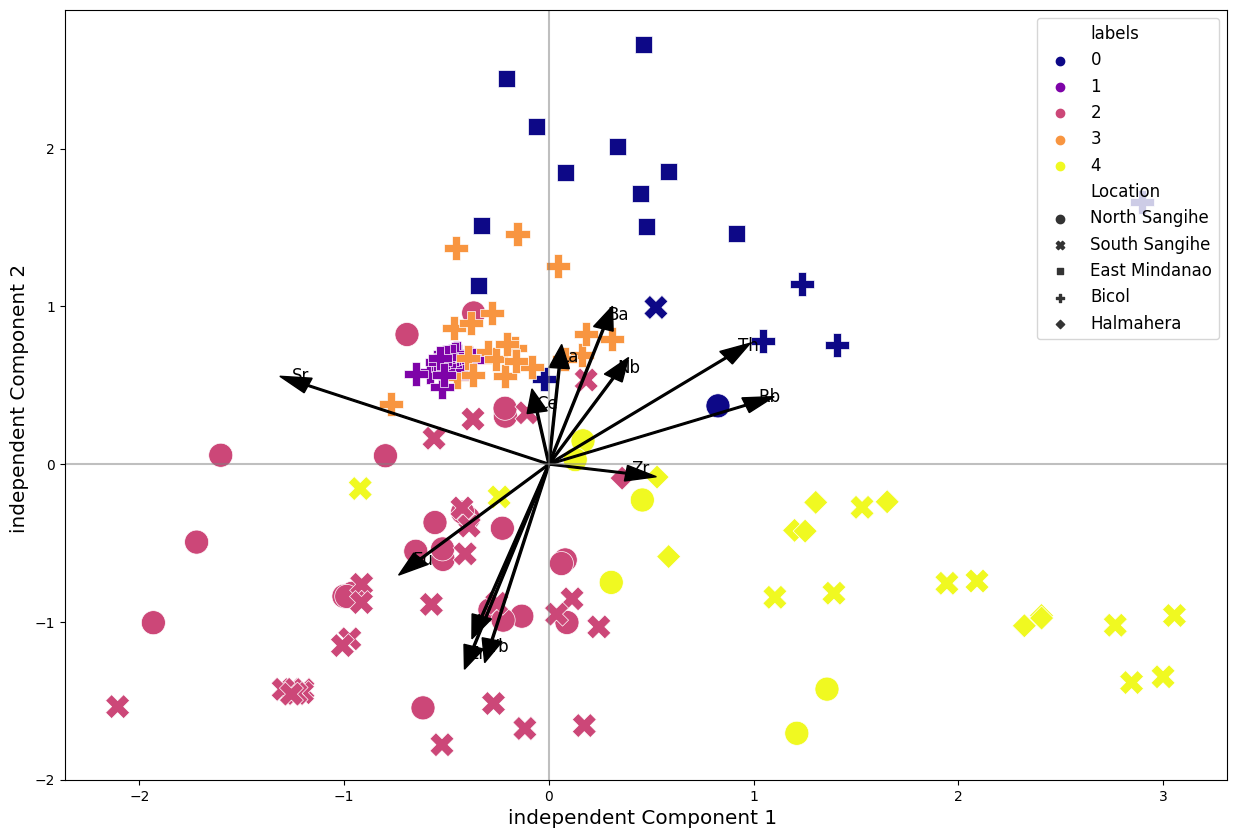

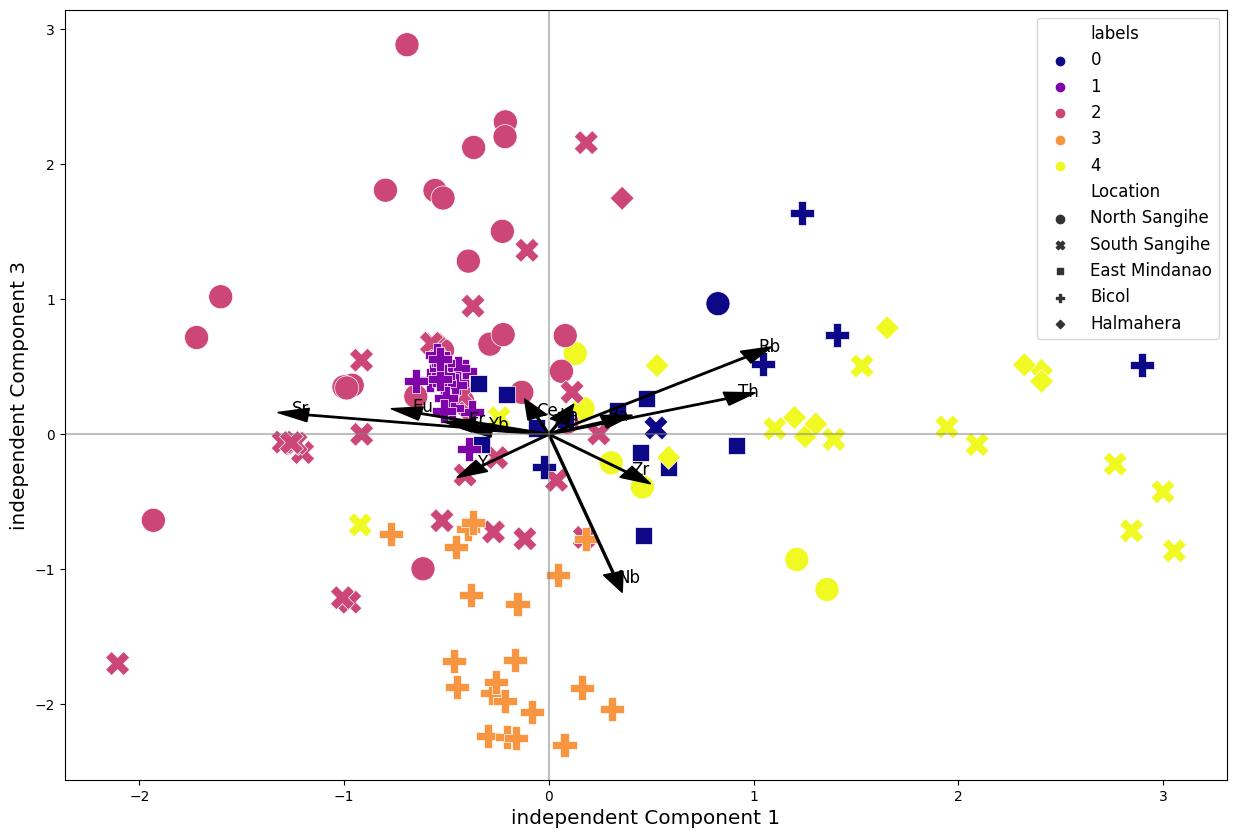

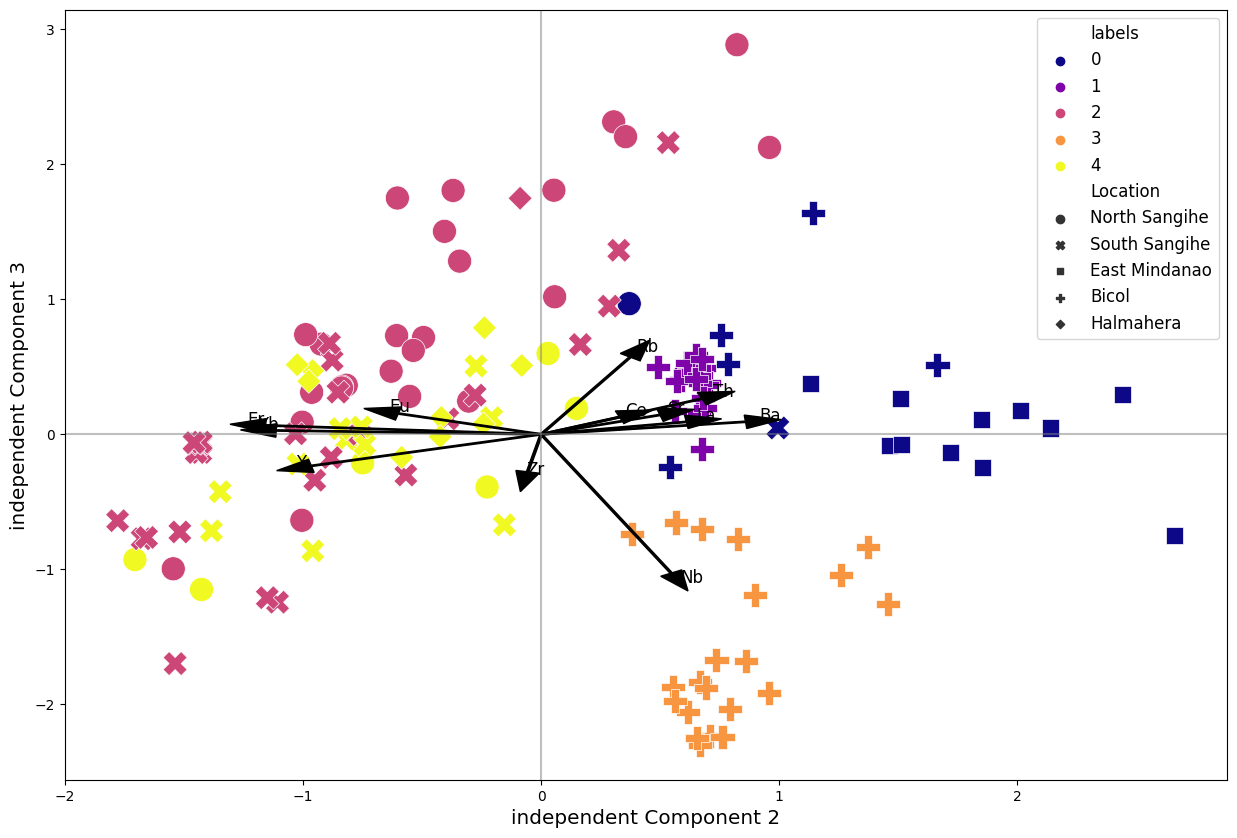

In [35]:
# ICA + Label
# IC1vsIC2
figx, ax = plt.subplots(figsize=(15, 10))
sns.scatterplot(data=pcIcAndOrginal,
                edgecolors="black",
                linewidth=0.5,
                x="IC1",
                y="IC2",
                s=300,
                palette='plasma',
                style="Location",
                hue="labels")
plt.legend(fontsize="large", loc=1)
plt.xlabel(f'independent Component 1 ', fontsize="x-large")
plt.ylabel(f'independent Component 2 ', fontsize="x-large")
for i, feature in enumerate(elements):
    plt.arrow(0,
              0,  
              arrow_multiplier * vectorData[i, 0],
              arrow_multiplier * vectorData[i, 1],
              color='black',
              width=0.01,
              head_width=0.1)
    plt.text(text_multiplier * vectorData[i, 0],
             text_multiplier * vectorData[i, 1],
             feature,
             fontsize="large")
ax.axhline(y=0, color='gray', alpha=0.5)
ax.axvline(x=0, color='gray', alpha=0.5)
plt.savefig(f'ICA_label_trace_{numberOfComponent}_1vs2.svg')
# IC1vsIC3
figy, ax = plt.subplots(figsize=(15, 10))
sns.scatterplot(data=pcIcAndOrginal,
                edgecolors="black",
                linewidth=0.5,
                x="IC1",
                y="IC3",
                s=300,
                palette='plasma',
                style="Location",
                hue="labels")
plt.legend(fontsize="large", loc=1)
plt.xlabel(f'independent Component 1', fontsize="x-large")
plt.ylabel(f'independent Component 3', fontsize="x-large")
for i, feature in enumerate(elements):
    plt.arrow(0,
              0,  
              arrow_multiplier * vectorData[i, 0],
              arrow_multiplier * vectorData[i, 2],
              color='black',
              width=0.01,
              head_width=0.1)
    plt.text(text_multiplier * vectorData[i, 0],
             text_multiplier * vectorData[i, 2],
             feature,
             fontsize="large")
ax.axhline(y=0, color='gray', alpha=0.5)
ax.axvline(x=0, color='gray', alpha=0.5)
plt.savefig(f'ICA_label_trace_{numberOfComponent}_1vs3.svg')
# IC2vsIC3
figz, ax = plt.subplots(figsize=(15, 10))
sns.scatterplot(data=pcIcAndOrginal,
                edgecolors="black",
                linewidth=0.5,
                x="IC2",
                y="IC3",
                s=300,
                palette='plasma',
                style="Location",
                hue="labels")
plt.legend(fontsize="large", loc=1)
plt.xlabel(f'independent Component 2', fontsize="x-large")
plt.ylabel(f'independent Component 3', fontsize="x-large")
for i, feature in enumerate(elements):
    plt.arrow(0,
              0,  
              arrow_multiplier * vectorData[i, 1],
              arrow_multiplier * vectorData[i, 2],
              color='black',
              width=0.01,
              head_width=0.1)
    plt.text(text_multiplier * vectorData[i, 1],
             text_multiplier * vectorData[i, 2],
             feature,
             fontsize="large")
ax.axhline(y=0, color='gray', alpha=0.5)
ax.axvline(x=0, color='gray', alpha=0.5)
plt.savefig(f'ICA_label_trace_{numberOfComponent}_2vs3.svg')

In [36]:
# Define a mapping of Location categories to symbols
location_symbol_mapping = {
    'North Sangihe': 'circle',
    'South Sangihe': 'circle-open',
    'East Mindanao': 'square',
    'Bicol': 'square-open',
    'Halmahera': 'diamond',
}

# Apply the mapping to the 'Location' column
pcIcAndOrginal['location_symbol'] = pcIcAndOrginal['Location'].map(location_symbol_mapping)

arrow_multiplier = 8.5
text_multiplier = 8.8

# Create 3D scatter plot
fig = go.Figure()

# Scatter plot for IC1, IC2, and IC3 with different symbols based on "Location"
fig.add_trace(go.Scatter3d(
    x=pcIcAndOrginal['IC1'],
    y=pcIcAndOrginal['IC2'],
    z=pcIcAndOrginal['IC3'],
    mode='markers',
    marker=dict(
        size=8,
        color=pcIcAndOrginal['labels'].astype('category').cat.codes,  # Color by 'Location'
        colorscale='rainbow',  # Color scale
        opacity=0.8,
        symbol=pcIcAndOrginal['location_symbol'],  # Use mapped symbols for locations
    ),
    text=pcIcAndOrginal['Location'],  # Text when hovering over points
    hoverinfo='text',
    name='Data Points',  # Name for the legend
))

# Add lines for each feature with a legend
for i, feature in enumerate(elements):
    fig.add_trace(go.Scatter3d(
        x=[0, arrow_multiplier * vectorData[i, 0]],  # Line from origin to scaled vector
        y=[0, arrow_multiplier * vectorData[i, 1]],  # Line from origin to scaled vector
        z=[0, arrow_multiplier * vectorData[i, 2]],  # Line from origin to scaled vector
        mode='lines',
        line=dict(color='black', width=4),  # Customize line color and width
        hoverinfo='none',  # Disable hover info for lines
        showlegend=True,
        name=feature,  # Feature name for the legend
    ))
    # Add feature names as text labels
    fig.add_trace(go.Scatter3d(
        x=[text_multiplier * vectorData[i, 0]],
        y=[text_multiplier * vectorData[i, 1]],
        z=[text_multiplier * vectorData[i, 2]],
        mode='text',
        text=[feature],
        showlegend=False,
    ))

# Customize layout with legend
fig.update_layout(
    scene=dict(
        xaxis_title='IC1',
        yaxis_title='IC2',
        zaxis_title='IC3',
        # Set background color
        xaxis=dict(backgroundcolor='lightgray'),
        yaxis=dict(backgroundcolor='lightgray'),
        zaxis=dict(backgroundcolor='lightgray'),
    ),  margin=dict(l=0, r=0, b=0, t=0),
        hovermode='closest',
    showlegend=False
    
)

# Show plot
display(fig)

## Map

In [37]:
def transform_latitude(lat):
    if lat < -6:
        return abs(lat)
    return lat

pcIcAndOrginal['Latitude'] = pcIcAndOrginal['Latitude'].apply(transform_latitude)

# Create geometry column with Point objects
pcIcAndOrginal['geometry'] = [Point(xy) for xy in zip(pcIcAndOrginal['Longitude'], pcIcAndOrginal['Latitude'])]

# Create a GeoDataFrame
geoDataframe = gpd.GeoDataFrame(pcIcAndOrginal, geometry='geometry')

# Set CRS to EPSG:4326 (WGS 84)
geoDataframe.set_crs(epsg=4326, inplace=True)

# Initialize a Folium map centered at the average latitude and longitude
map_center = [geoDataframe['Latitude'].mean(), geoDataframe['Longitude'].mean()]

# Gaussian Mixture Model Labels
m = folium.Map(location=map_center, zoom_start=5, tiles=None)

# Add Esri World Terrain basemap
folium.TileLayer('Esri.WorldTerrain').add_to(m)

# Create a color scale
color_scale = cm.LinearColormap(
    colors=['blue', 'green', 'yellow', 'orange', 'red'],  # Define color gradient
    vmin=geoDataframe['labels'].min(),  # Minimum value for scaling
    vmax=geoDataframe['labels'].max()   # Maximum value for scaling
)

# Function to create gradient circle marker
def create_gradient_circle(value, scale):
    color = scale(value)
    return f"""
    <div style="
        width: 20px; 
        height: 20px; 
        border-radius: 50%; 
        background: radial-gradient(circle, {color} 0%, rgba(255,255,255,0) 90%);
        border: 1px solid black;
    "></div>
    """

# Add markers with continuous color scale
for idx, row in geoDataframe.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=f"{row['Sample Name']}: {row['Location']}",
        icon=folium.DivIcon(
            html=create_gradient_circle(row['labels'], color_scale)
        )
    ).add_to(m)

# Add color scale legend to the map
color_scale.add_to(m)

# Display the map inline
display(m)


/opt/conda/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:131: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.



In [38]:
# IC1
x = folium.Map(location=map_center, zoom_start=5, tiles=None)

# Add Esri World Terrain basemap
folium.TileLayer('Esri.WorldTerrain').add_to(x)

# Create a color scale
color_scale = cm.LinearColormap(
    colors=['blue', 'green', 'yellow', 'red'],  # Define color gradient
    vmin=geoDataframe['IC1'].min(),  # Minimum value for scaling
    vmax=geoDataframe['IC1'].max()   # Maximum value for scaling
)

# Function to create gradient circle marker
def create_gradient_circle(value, scale):
    color = scale(value)
    return f"""
    <div style="
        width: 20px; 
        height: 20px; 
        border-radius: 50%; 
        background: radial-gradient(circle, {color} 0%, rgba(255,255,255,0) 70%);
        border: 1px solid black;
    "></div>
    """

# Add markers with continuous color scale
for idx, row in geoDataframe.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=f"{row['Sample Name']}: {row['Location']}",
        icon=folium.DivIcon(
            html=create_gradient_circle(row['IC1'], color_scale)
        )
    ).add_to(x)

# Add color scale legend to the map
color_scale.add_to(x)

# Display the map inline
display(x)

In [39]:
# IC 2
l = folium.Map(location=map_center, zoom_start=5, tiles=None, )

# Add Esri World Terrain basemap
folium.TileLayer('Esri.WorldTerrain').add_to(l)

# Create a color scale
color_scale = cm.LinearColormap(
    colors=['blue', 'green', 'yellow', 'red'],  # Define color gradient
    vmin=geoDataframe['IC2'].min(),  # Minimum value for scaling
    vmax=geoDataframe['IC2'].max()   # Maximum value for scaling
)

# Function to create gradient circle marker
def create_gradient_circle(value, scale):
    color = scale(value)
    return f"""
    <div style="
        width: 20px; 
        height: 20px; 
        border-radius: 50%; 
        background: radial-gradient(circle, {color} 0%, rgba(255,255,255,0) 70%);
        border: 1px solid black;
    "></div>
    """

# Add markers with continuous color scale
for idx, row in geoDataframe.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=f"{row['Sample Name']}: {row['Location']}",
        icon=folium.DivIcon(
            html=create_gradient_circle(row['IC2'], color_scale)
        )
    ).add_to(l)

# Add color scale legend to the map
color_scale.add_to(l)

# Display the map inline
display(l)

In [40]:
# IC 3
k = folium.Map(location=map_center, zoom_start=5, tiles=None)

# Add Esri World Terrain basemap
folium.TileLayer('Esri.WorldTerrain').add_to(k)

# Create a color scale
color_scale = cm.LinearColormap(
    colors=['blue', 'green', 'yellow', 'red'],  # Define color gradient
    vmin=geoDataframe['IC3'].min(),  # Minimum value for scaling
    vmax=geoDataframe['IC3'].max()   # Maximum value for scaling
)

# Function to create gradient circle marker
def create_gradient_circle(value, scale):
    color = scale(value)
    return f"""
    <div style="
        width: 20px; 
        height: 20px; 
        border-radius: 50%; 
        background: radial-gradient(circle, {color} 0%, rgba(255,255,255,0) 70%);
        border: 1px solid black;
    "></div>
    """

# Add markers with continuous color scale
for idx, row in geoDataframe.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=f"{row['Sample Name']}: {row['Location']}",
        icon=folium.DivIcon(
            html=create_gradient_circle(row['IC3'], color_scale)
        )
    ).add_to(k)

# Add color scale legend to the map
color_scale.add_to(k)

# Display the map inline
display(k)

In [41]:
pcIcAndOrginal

PC1       PC2       PC3       Location  Longitude  Latitude  \
0   -0.552136 -0.166807  1.836955  North Sangihe    125.800     4.500   
1   -0.458999 -0.074990  1.304177  North Sangihe    125.700     4.233   
2   -0.529301  1.834104 -1.246265  North Sangihe    125.716     3.866   
3   -0.878332  0.415956  0.313675  North Sangihe    125.583     3.783   
4   -0.418545  0.112699  1.512626  North Sangihe    125.583     3.783   
..        ...       ...       ...            ...        ...       ...   
133  0.693484  1.572232  0.674178      Halmahera    127.330     0.800   
134  0.224865  0.520912  0.472374      Halmahera    127.350     0.300   
135  0.299575  1.282749 -0.103452      Halmahera    127.350     0.300   
136  0.484314  1.235928 -0.013100      Halmahera    127.350     0.300   
137  0.167172  0.454837  1.719114      Halmahera    127.350     0.300   

                  AGE         Sample Name Island Arc  SiO2  ...        Yb  \
0    PLIOCENE [16735]  s_PJ-40-78 [16735]    Sangihe   NaN  ...  0.254873   
1    PLIOCENE [16735]  s_PJ-43-78 [16735]    Sangihe   NaN  ...  0.251508   
2    PLIOCENE [16735]  s_PJ-45-78 [16735]    Sangihe   NaN  ...  0.527006   
3    PLIOCENE [16735]    s_PBUANG [16735]    Sangihe  55.6  ...  0.485924   
4    PLIOCENE [16735]   s_PJ-5-78 [16735]    Sangihe   NaN  ...  0.262250   
..                ...                 ...        ...   ...  ...       ...   
133               NaN        s_GL [25001]  Halmahera  56.6  ...  0.037949   
134               NaN       s_MK1 [25001]  Halmahera  50.0  ... -0.000321   
135               NaN       s_MK2 [25001]  Halmahera  53.3  ...  0.058451   
136               NaN       s_MK3 [25001]  Halmahera  55.8  ...  0.005134   
137               NaN       s_MK4 [25001]  Halmahera  50.0  ...  0.044833   

           Th        Nb        Zr         Y       IC1       IC2       IC3  \
0   -0.413153 -0.870201 -0.110410  0.181223 -0.556485 -0.369754  1.805738   
1   -0.291449 -0.733261 -0.007072  0.169978 -0.393659 -0.342347  1.282580   
2   -0.313693  0.053677  0.594235  0.271216  1.357815 -1.426019 -1.148949   
3   -0.516492 -0.490717  0.090548  0.437412 -0.132409 -0.963614  0.311118   
4   -0.307910 -0.644128 -0.218868  0.159787 -0.227443 -0.405981  1.503119   
..        ...       ...       ...       ...       ...       ...       ...   
133  0.784148 -0.340112  0.059147  0.012113  1.651776 -0.238316  0.788791   
134  0.431778 -0.323646 -0.025183  0.193586  0.527887 -0.081657  0.509626   
135  0.417464 -0.146565  0.237111  0.194043  1.251243 -0.424270 -0.016608   
136  0.388129 -0.136680  0.265484  0.185159  1.302985 -0.242169  0.076377   
137  0.498209 -0.950363  0.023572  0.281431  0.357409 -0.088386  1.747748   

     location_symbol               geometry  
0             circle      POINT (125.8 4.5)  
1             circle    POINT (125.7 4.233)  
2             circle  POINT (125.716 3.866)  
3             circle  POINT (125.583 3.783)  
4             circle  POINT (125.583 3.783)  
..               ...                    ...  
133          diamond     POINT (127.33 0.8)  
134          diamond     POINT (127.35 0.3)  
135          diamond     POINT (127.35 0.3)  
136          diamond     POINT (127.35 0.3)  
137          diamond     POINT (127.35 0.3)  

[138 rows x 28 columns]

In [42]:
pcIcAndOrginal["Rb/Sr"] = pcIcAndOrginal["Rb"] / pcIcAndOrginal["Sr"]
pcIcAndOrginal["Th/Eu"] = pcIcAndOrginal["Th"] /pcIcAndOrginal["Eu"] 

<Axes: xlabel='Rb/Sr', ylabel='Th/Eu'>

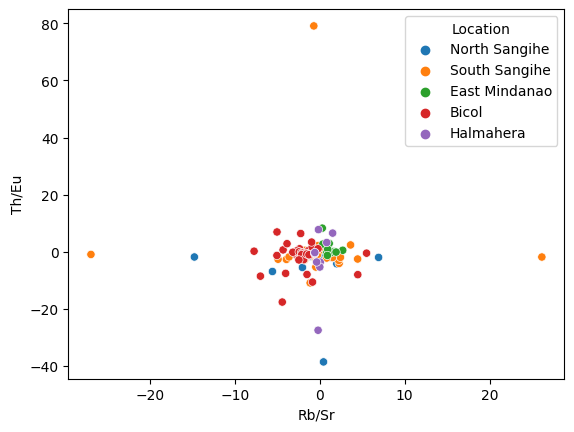

In [43]:
sns.scatterplot(data=pcIcAndOrginal, x="Rb/Sr", y="Th/Eu", hue="Location")

<Axes: xlabel='Sr', ylabel='Th'>

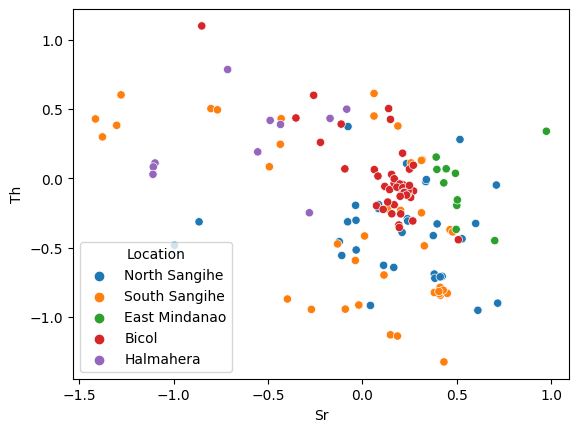

In [44]:
sns.scatterplot(data=pcIcAndOrginal, x="Sr", y="Th", hue="Location")

<Axes: xlabel='Sr', ylabel='Rb'>

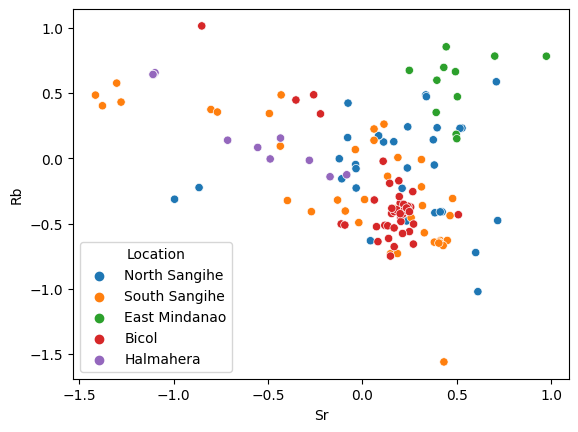

In [45]:
sns.scatterplot(data=pcIcAndOrginal, x="Sr", y="Rb", hue="Location")

<Axes: xlabel='Sr', ylabel='Eu'>

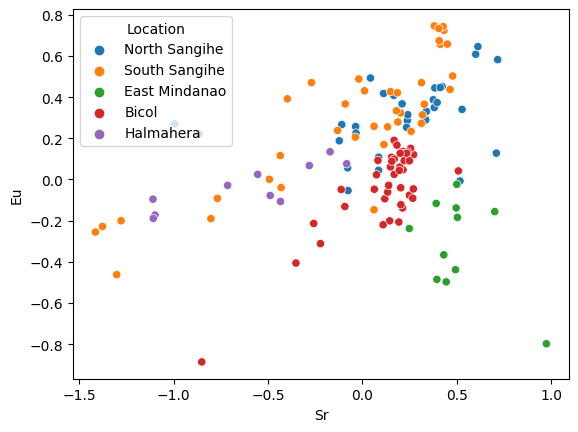

In [46]:
sns.scatterplot(data=pcIcAndOrginal, x="Sr", y="Eu", hue="Location")

<Axes: xlabel='Rb', ylabel='Th'>

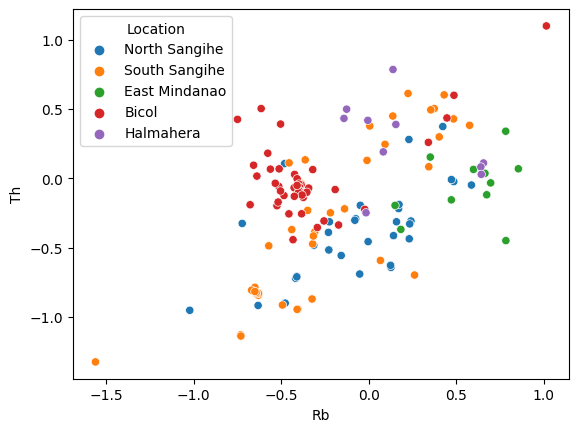

In [47]:
sns.scatterplot(data=pcIcAndOrginal, x="Rb", y="Th", hue="Location")

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warn

<Axes: xlabel='Rb/Sr', ylabel='Density'>

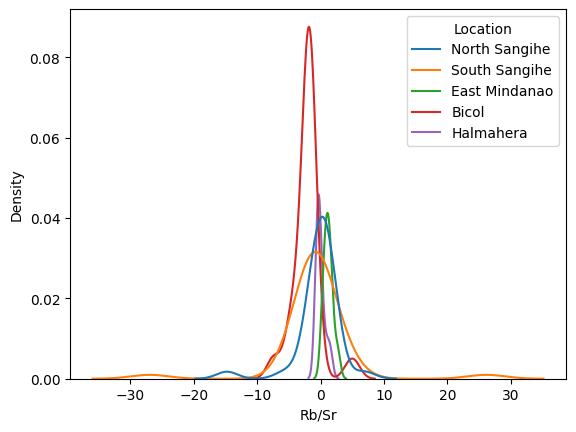

In [48]:
sns.kdeplot(data=pcIcAndOrginal, x="Rb/Sr", hue="Location")

In [49]:
data = pcIcAndOrginal[["Rb/Sr", "Th/Eu"]]
zScore = np.abs(st.zscore(data))
cleanDataZScore1 = data[(zScore < 3).all(axis=1)]
cleanDataZScore = cleanDataZScore1

In [50]:
cleanDataZScore

Rb/Sr     Th/Eu
0    0.377272 -1.066013
1   -0.310545 -1.015977
2    0.258723 -1.418142
3    6.927146 -2.003269
4    1.002283 -0.979060
..        ...       ...
132  0.054166 -3.669139
134  0.823304  3.207841
135  0.009856 -5.372955
136 -0.357321 -3.626281
137  1.519344  6.515197

[132 rows x 2 columns]

In [51]:
frameData=pcIcAndOrginal["Location"]
concatData = pd.concat([cleanDataZScore, frameData], axis=1, join='inner')

<Axes: xlabel='Rb/Sr', ylabel='Th/Eu'>

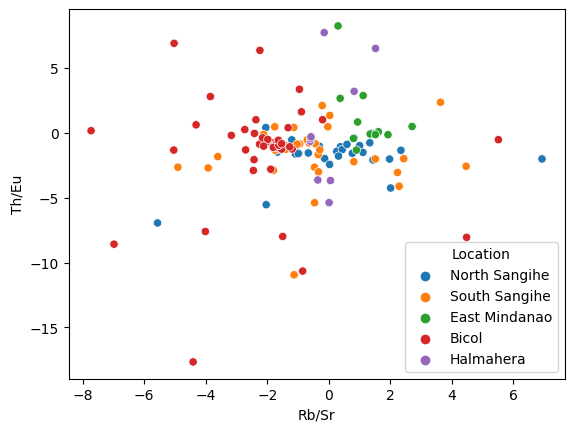

In [52]:
sns.scatterplot(data=concatData, x="Rb/Sr", y="Th/Eu", hue="Location")